In [1]:
from uncertainties import ufloat
from uncertainties.umath import *
import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from astropy.stats import LombScargle
from scipy import signal
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
import scipy.optimize
import glob
from astropy.table import Table,join,vstack,unique
from importlib import reload
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sb
import scipy.stats as st
import wotan
from lmfit.models import GaussianModel
import ogle as o #module
from matplotlib.lines import Line2D
import matplotlib.patches as patches
from matplotlib.patches import Rectangle as rec

blue = 'cornflowerblue'
navy = 'navy'
purple = 'rebeccapurple'
pink = '#CF6275'
maroon = 'maroon'

cross = Table.read('sourcefiles.csv')
full = Table.read('smc_x_m03_zar_match_OGLE_v2.ascii',format='ascii')

summ = pd.read_csv('summtab.csv')
alls = pd.read_csv('allsummtab.csv') #more updated that summ, but not final

cross['Part'] = 1
cross2 = Table.read('part2files.csv')
cross2 = join(cross2,full,keys='src_n')
cross2['Part'] = 2

mlist2 = ['OII I','OIII I','OIV I']
mlist1 = ['OII I','OIII I']

srcns = np.array(alls['src_n'])
#saving figure function
def sf(name,dpi=150):
    plt.savefig(f'Figs/{name}.png',bbox_inches='tight',dpi=dpi)

In [2]:
def plot(s,calib=False,both=True,fs=(4,3),new=True):
    try:band = o.getIV(s,cross,both=both,stack=True,plot=new,mlist=mlist1,figsize=fs,calib=calib)
    except:band = o.getIV(s,cross2,both=both,stack=True,plot=new,mlist=mlist2,figsize=fs,calib=calib)
    if not new:
        plt.scatter(band[0]['MJD-50000'],band[0]['I mag'],color=pink,s=5)
        plt.scatter(band[1]['MJD-50000'],band[1]['V mag'],color='navy',s=5)
        plt.ylim(np.max(band[0]['I mag'])+.1,np.min(band[0]['I mag'])-.1)

# Super-orbital Periodicities?
- one source has est. period of 1163, which is **not correct** (see below)
- checked the super-orbital periodicities given in Rajoelimanana
- certainly quasi-periodicity but no evidence of proper super-orbital periodicity

In [3]:
iband = o.getIV(48,cross,stack=True,both=False)

1163 doesn't seem to actually be the orbital period for this source

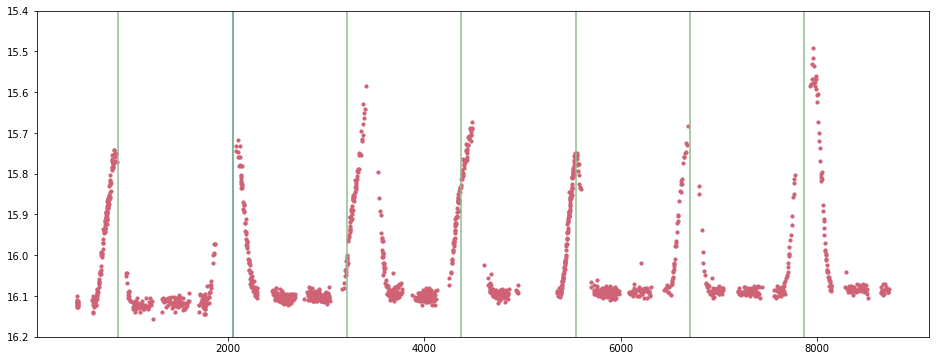

In [4]:
plt.figure(figsize=(16,6))
plt.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=10)
plt.ylim(16.2,15.4)
plt.axvline(2050)
for i in range(-1,6):
    plt.axvline(2050+i*1163,color='darkseagreen')

In [5]:
type4_old = o.gettype(alls,num='4')
type4_old

[5, 6, 9, 10, 60, 63]

In [6]:
#table with super-orbital periodicities from Rajoelimanana
sup = alls[alls['Raj superorbital']>0]

In [7]:
sup['Raj superorbital']

1     2800.0
5      621.0
7     1116.0
8      397.0
9     1786.0
10    1886.0
14    1515.0
23    1220.0
26     758.0
27    2700.0
28     492.0
34    1220.0
35    3000.0
37    2000.0
38    2000.0
44    1274.0
47    1886.0
49    3000.0
51    2857.0
Name: Raj superorbital, dtype: float64

In [5]:
#from plots: also don't look periodic -- maybe the superorbital timescale
#for s in sup['src_n']: plot(s)

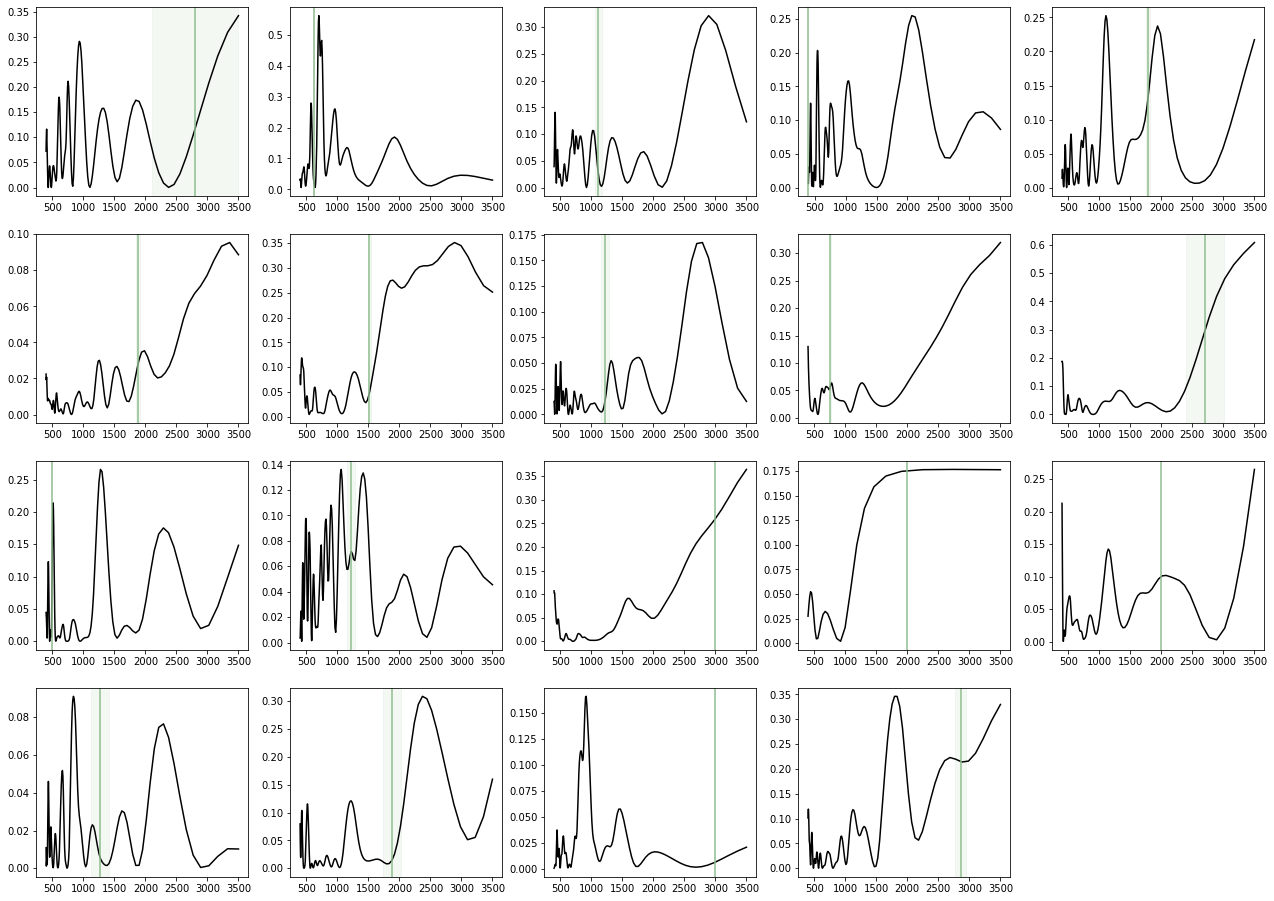

In [58]:
#first just run periodogram -- these aren't really significant
#line where Rajoelimanana period is; shading is error
fig = plt.figure(figsize=(22,16))
c = 1
for s in sup['src_n']:
    try: iband = o.getIV(s,cross,stack=True,both=False)
    except: iband = o.getIV(s,cross2,mlist=mlist2,stack=True,both=False)
    #get superorbital
    sp = float(sup[sup['src_n']==s]['Raj superorbital'])
    spe = float(sup[sup['src_n']==s]['Raj superorbital err'])
    #plot periodogram
    ax = fig.add_subplot(4,5,c)
    freq,power,bp = o.periodogram(iband,minp=400,maxp=3500,more=True,plot=False)
    ax.plot(1/freq,power,color='black')
    if not np.isnan(spe): ax.axvspan(sp-spe,sp+spe,alpha=0.1,color='darkseagreen')
    ax.axvline(sp,color='darkseagreen')
    c+=1

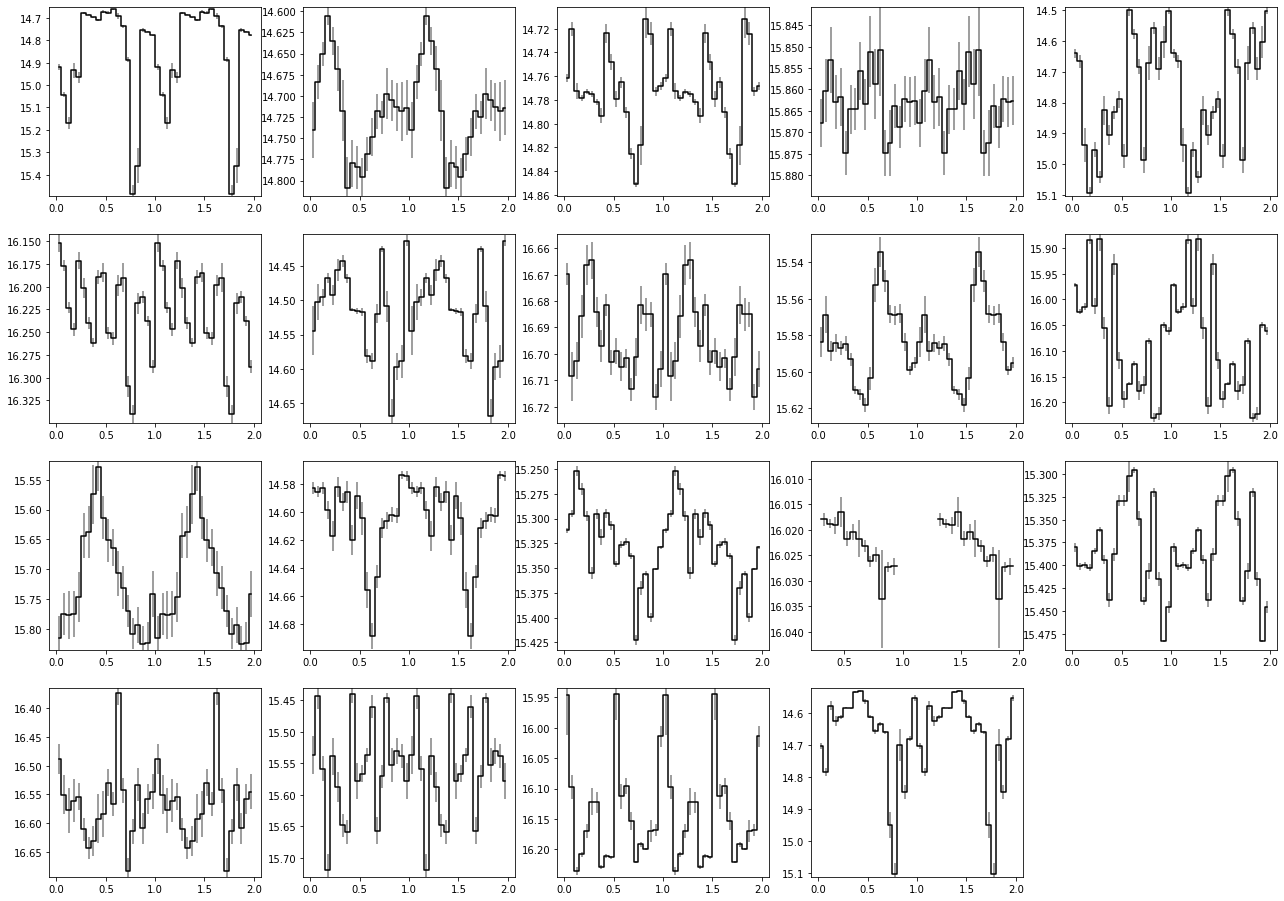

In [61]:
# now phase fold with these periods -- some actually look good so look back at data
#don't really seem significant -- a couple features can make this look decent
fig = plt.figure(figsize=(22,16))
c = 1
for s in sup['src_n']:
    try: iband = o.getIV(s,cross,stack=True,both=False)
    except: iband = o.getIV(s,cross2,mlist=mlist2,stack=True,both=False)
    #get superorbital
    sp = float(sup[sup['src_n']==s]['Raj superorbital'])
    spe = float(sup[sup['src_n']==s]['Raj superorbital err'])
    #plot periodogram
    ax = fig.add_subplot(4,5,c)
    mid,avg,err = o.meanphase(iband,sp,double=True,divide=True,sterr=True,stdev=True)
    ax.step(mid,avg,where='mid',color='black')
    ax.errorbar(mid,avg,yerr=err,color='black',alpha=0.5,linestyle='none')
    ax.set_ylim(np.nanmax(avg)+.01,np.nanmin(avg)-.01)
    c+=1

# Looking into Galache 2008 New Sources

- not clear how trustworthy these periods are, even though they were found using X-ray data
- src 19: we have est. 17.79; Galache has 17.7 so look into that
    - very noisy periodogram
- can try out src 24: we have est. 62.1, and Galache has 122
- similarly for src 26
- **src 27: 362, in agreement**
- src 28: 117 (not in agreement)

<Quantity 17.83714272>

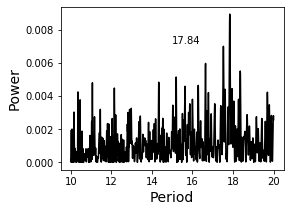

In [10]:
iband = o.getIV(19,cross2,mlist=mlist2,stack=True,both=False)
o.splinedetrend(iband)
o.periodogram(iband,det=False,minp=10,maxp=20)

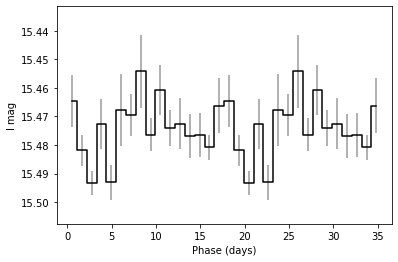

In [13]:
o.phasestep(iband,17.7,16,det=True)

<Quantity 120.18042537>

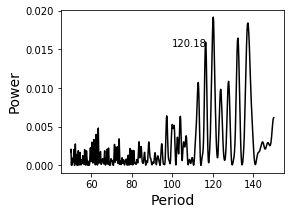

In [15]:
#overall peak closer to Galache
iband = o.getIV(24,cross,stack=True,both=False)
o.splinedetrend(iband)
o.periodogram(iband,det=False,minp=50,maxp=150)

<Quantity 63.50581446>

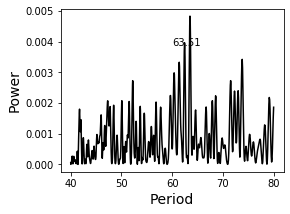

In [16]:
o.periodogram(iband,det=False,minp=40,maxp=80)

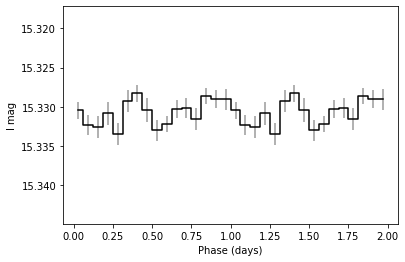

In [19]:
#doesn't look good with either period
o.phasestep(iband,62.1,16,det=True,divide=True)

21    60.913413
Name: best auto det pd, dtype: float64


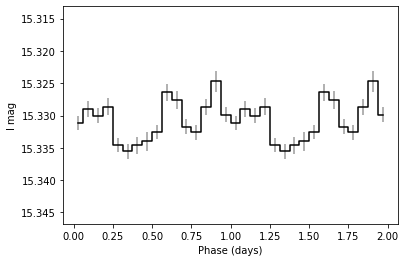

In [24]:
#use best found period -- a little better
bp = alls[alls['src_n']==24]['best auto det pd']
print(bp)
o.phasestep(iband,float(bp),16,det=True,divide=True)

In [37]:
alls[alls['src_n']==26]['references']

23    Galache 2008: 61.6
Name: references, dtype: object

23    33.406866
Name: best auto det pd, dtype: float64


<Quantity 33.32811973>

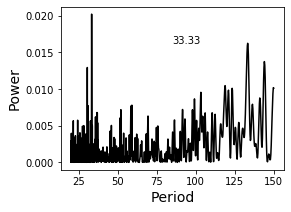

In [27]:
bp = alls[alls['src_n']==26]['best auto det pd']
print(bp)
iband = o.getIV(26,cross,stack=True,both=False)
o.splinedetrend(iband)
o.periodogram(iband,det=False,minp=20,maxp=150)
#better than Galache

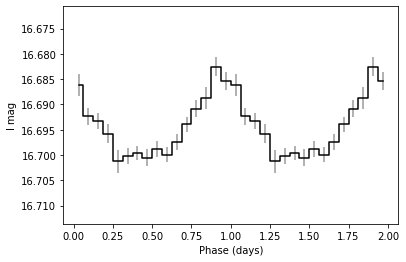

In [34]:
o.phasestep(iband,float(bp),16,det=True,divide=True)

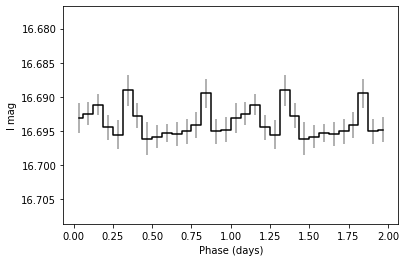

In [35]:
#from Galache: doesn't look good
o.phasestep(iband,61.6,16,det=True,divide=True)

# some correlations, by type
- but should edit to use quantitiy other than I V-I slope

In [103]:
#mostly using old type names but in legend they will be labeled by final numbering
type1 = o.gettype(alls,num='1') #final 1
type2 = o.gettype(alls,num='2') #final 2
type3 = o.gettype(alls,num='3') #also final 2
type4 = [60,63] #final 4
type5 = o.gettype(alls,num='5')+[5, 6, 9, 10] #final 3
type6 = o.gettype(alls,num='6') #final 5
type7 = o.gettype(alls,num='7') #final 6
#transition sources
typet = []
for i in range(len(alls)):
    row = alls.iloc[i]
    src = row['src_n']
    if '+' in str(row['type']):
        typet.append(int(src))

In [141]:
def fulltplot(x='stdev I',y='det stdev I',legend=True,tbool=[False]*7,between=False,tab=alls):
    if between and len(tbool)==7: tbool.append(False) #make sure tbool is right length 
    o.tplot(type1,tab,color=pink,marker='*',label='1',x=x,y=y,text=tbool[0])
    o.tplot(type2,tab,color='black',label='2',x=x,y=y,text=tbool[1])
    o.tplot(type3,tab,color='black',marker='o',label='',x=x,y=y,text=tbool[2])
    o.tplot(type4,tab,color='rebeccapurple',marker='P',label='4',x=x,y=y,text=tbool[3])
    o.tplot(type5,tab,marker='v',label='3',color='maroon',x=x,y=y,text=tbool[4])
    o.tplot(type6,tab,marker='3',label='5',color='grey',x=x,y=y,text=tbool[5])
    o.tplot(type7,tab,color='darkseagreen',marker='h',label='6',x=x,y=y,text=tbool[6])
    #if between, also plot transition sources
    if between: o.tplot(typet,tab,marker='p',label='transition',color='navy',x=x,y=y,text=tbool[7])
    plt.ylabel(y,fontsize=14)
    plt.xlabel(x,fontsize=14)
    if legend: plt.legend()

(-10, 500)

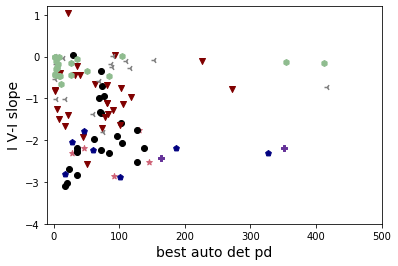

In [143]:
fulltplot(x='best auto det pd',y='I V-I slope',legend=False,between=True)
# plt.xlim(-100,1500)
# plt.xscale('log')
plt.ylim(-4,1.2)
plt.xlim(-10,500)
#cut out type 1 with 1163

In [144]:
#manually change type 4 values
acopy = alls.copy()
row = acopy[acopy['src_n']==60]
row['best auto det pd'] = 393
acopy[acopy['src_n']==60] = row

row = acopy[acopy['src_n']==63]
row['best auto det pd'] = 656
acopy[acopy['src_n']==63] = row

(1.5, 750)

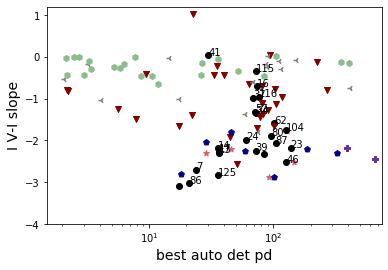

In [145]:
#same but log scale
fulltplot(x='best auto det pd',y='I V-I slope',legend=False,tab=acopy,
         tbool=[False,True,True,False,False,False,False],between=True)
# plt.xlim(-100,1500)
plt.xscale('log')
plt.ylim(-4,1.2)
plt.xlim(1.5,750)
#cut out type 1 with 1163
# sf('slope_pd_bytype')

In [32]:
# alls.columns

remember: would probably want to take out aperiodic sources

(-20, 750)

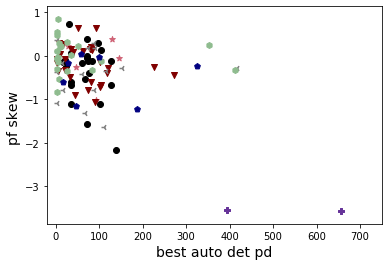

In [146]:
fulltplot(x='best auto det pd',y='pf skew ',legend=False,tab=acopy,
         tbool=[False,False,False,False,False,False,False],between=True)
# plt.xlim(-100,1500)
# plt.xscale('log')
# plt.ylim(-4,1.2)
plt.xlim(-20,750)

(1.5, 750)

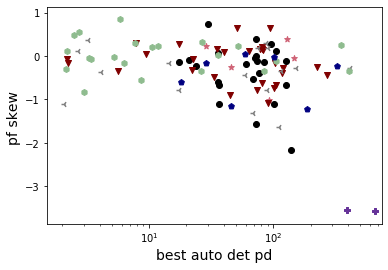

In [147]:
#same with log scale: no proper relation
fulltplot(x='best auto det pd',y='pf skew ',legend=False,tab=acopy,
         tbool=[False,False,False,False,False,False,False],between=True)
# plt.xlim(-100,1500)
plt.xscale('log')
# plt.ylim(-4,1.2)
plt.xlim(1.5,750)
# plt.ylim(-.001,.006)

(-0.001, 0.02)

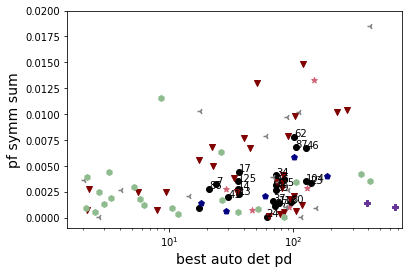

In [148]:
#symmetry and period
#higher value of symm sum means less symmetric (but need to check if confounding with higher amp)
#can always recalculate with symm function in ogle.py if not sure (not sure if return from that divided by amp or something)
fulltplot(x='best auto det pd',y='pf symm sum',legend=False,tab=acopy,
         tbool=[False,True,True,False,False,False,False],between=True)
# plt.xlim(-100,1500)
plt.xscale('log')
# plt.ylim(-4,1.2)
plt.xlim(1.5,750)
plt.ylim(-.001,.02)

In [24]:

# fulltplot(x='pf amp',y='pf symm sum',legend=False,tab=acopy,
#          tbool=[False,False,False,False,False,False,False])
# plt.xlim(-.02,.2)
# plt.ylim(-.005,.04)

(-0.01, 0.4)

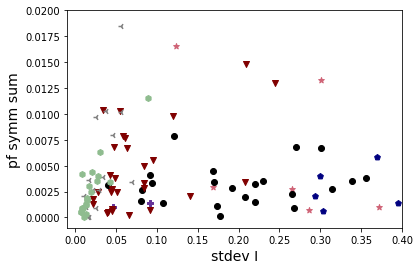

In [149]:
fulltplot(x='stdev I',y='pf symm sum',legend=False,tab=acopy,
         tbool=[False,False,False,False,False,False,False],between=True)
plt.ylim(-.001,.02)
plt.xlim(-.01,.4)

In [25]:
spins = acopy[acopy['spin period']>0]#table with spin periods (greater than 0)

(-50, 700)

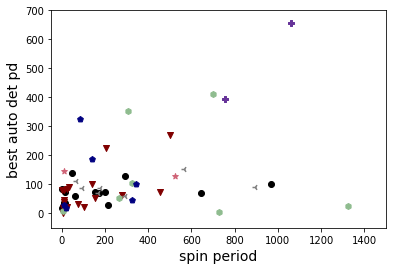

In [150]:
fulltplot(x='spin period',y='best auto det pd',legend=False,tab=spins,between=True)
plt.xlim(-50,1500)
plt.ylim(-50,700)

not horrible but not as good as Corbet

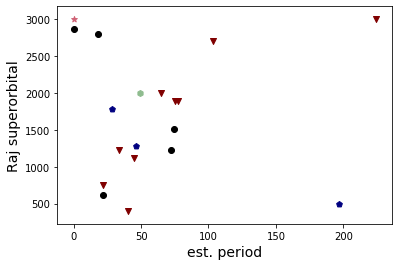

In [151]:
fulltplot(x='est. period',y='Raj superorbital',legend=False,tab=acopy,between=True)

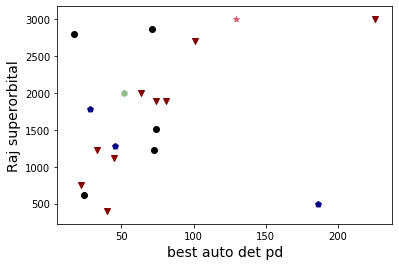

In [152]:
fulltplot(x='best auto det pd',y='Raj superorbital',legend=False,tab=acopy,between=True)

In [153]:
acopy2 = acopy[acopy['aperiodic']!='YES']

In [154]:
len(acopy2)

95

Text(0.5, 0, 'Spin Period (s)')

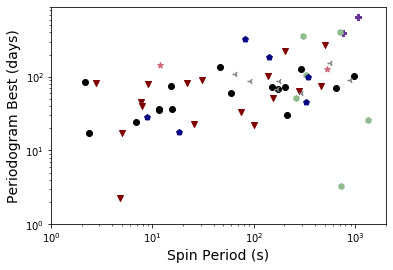

In [155]:
#Corbet
fulltplot(x='spin period',y='best auto det pd',legend=False,tab=acopy2,between=True)
plt.xlim(1,2000)
plt.ylim(1,900)
plt.yscale('log')
plt.xscale('log')
plt.ylabel('Periodogram Best (days)')
plt.xlabel('Spin Period (s)')
# sf('optical_spin_bytype')

Text(0, 0.5, 'Spin Period (s)')

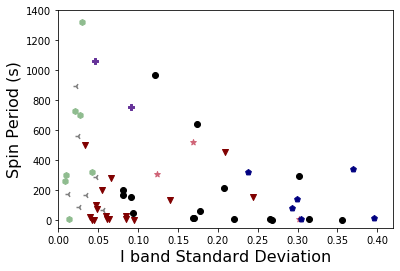

In [157]:
fulltplot(tab=spins,x='stdev I',y='spin period',between=True,legend=False)
plt.ylim(-50,1400)
plt.xlim(0,0.42)
plt.xlabel('I band Standard Deviation',fontsize=16)
plt.ylabel('Spin Period (s)',fontsize=16)

Text(0, 0.5, 'I V-I Slope')

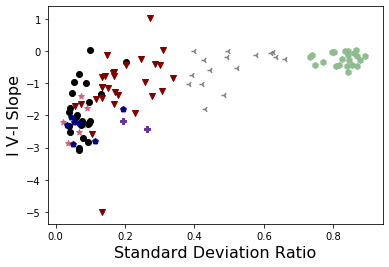

In [158]:
fulltplot(tab=acopy,x='sig stdev ratio',y='I V-I slope',between=True,legend=False)
plt.xlabel('Standard Deviation Ratio',fontsize=16)
plt.ylabel('I V-I Slope',fontsize=16)

Text(0.07, -0.45, 'transition')

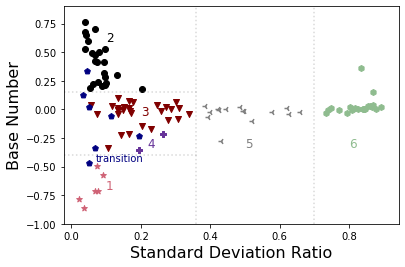

In [159]:
#type differentiation plot
fulltplot(tab=acopy,x='sig stdev ratio',y='base num',between=True,legend=False)
plt.ylabel('Base Number',fontsize=16)
plt.xlabel('Standard Deviation Ratio',fontsize=16)
plt.ylim(-1,0.9)
#manual legend

#defining separations
plt.axvline(0.7,color='grey',alpha=0.3,ls='dotted')
plt.axvline(0.36,color='grey',alpha=0.3,ls='dotted')
plt.axhline(-0.4,color='grey',alpha=0.3,ls='dotted',xmin=0,xmax=0.4)
plt.axhline(.15,color='grey',alpha=0.3,ls='dotted',xmin=0,xmax=0.4)
plt.text(0.1,-0.7,'1',color=pink,fontsize=12)
plt.text(0.1,0.6,'2',color='black',fontsize=12)
plt.text(0.2,-.05,'3',color='maroon',fontsize=12)
plt.text(0.22,-0.33,'4',color='rebeccapurple',fontsize=12)
plt.text(0.5,-0.33,'5',color='grey',fontsize=12)
plt.text(0.8,-0.33,'6',color='darkseagreen',fontsize=12)
plt.text(0.07,-0.45,'transition',color='navy',fontsize=10)

# Color-Magnitude Summary

explanation of min and max plots 
- two versions for each
    - color at absolute min
    - color at absolute max
    - mean and stdev color within 0.1 of each of those

In [51]:
iband,vband = o.getIV(48,cross,stack=True,both=True)
iband.sort('I mag',reverse=False) #ascending naturally

In [52]:
iband[:3]

<Table length=3>
MJD-50000   I mag  I mag err
 float64   float64  float64 
---------- ------- ---------
7957.93706  15.492     0.003
7960.92458  15.517     0.003
7944.86252  15.532     0.003

In [130]:
def typecm(mrange=0.1,bright=True,one=False,num=1,legend=False):#min (brightest) from color mag
    '''one: just use one point (brightest/faintest and associated color)
    num: ranking of brightness/dimmest (default absolute brightest/dimmest)'''
    lab = [False]*7 #turn to true once labeled
    # labels = np.arange(1,7) 
    colors = [pink,'black','maroon','rebeccapurple','grey','darkseagreen','navy']
    markers = ['*','o','v','P','3','h','p']
    ims = []#list of min I values
    for s in range(len(alls)):
        row = alls.iloc[s]
        src = int(row['src_n'])
        try:
            try:typ = int(row['type'])
            except: 
                typ = str(row['type'])
                if '+' in typ: typ = 8 #transition source -- call 8 for indexing
            #redirect types since not changed yet
            #careful if changed to final types in table
            if typ == 4 and src != 60 and src != 63: typ = 3
            elif typ == 3: typ = 2
            elif typ == 5: typ = 3
            elif typ == 6: typ = 5
            elif typ == 7: typ = 6
            elif typ == 8:typ = 7 #transition
            #get LC
            if typ == 6: calib=True
            else: calib=False
            try:iband,vband = o.getIV(src,cross,stack=True,calib=calib)
            except:iband,vband = o.getIV(src,cross2,mlist=mlist2,stack=True,calib=calib) 
            #interpolate iband
            interp = o.colormag(iband,vband,plot=False,retint=True,printcorr=False)
            #get brightest 0.1 mags
            vi = vband['V mag'] - interp
            vband['V-I'] = vi; vband['I'] = interp
            #table where I band within brightest 0.1 mags
            if bright:
                cutoff = np.min(interp)+mrange
                tab = vband[vband['I']<cutoff]
            else: 
                cutoff = np.max(interp)-mrange 
                tab = vband[vband['I']>cutoff]
            vimean = np.nanmedian(tab['V-I'])
            vistd = np.nanstd(tab['V-I'])
            if one: 
                #find V-I corresponding to min or max
                tab.sort('I',reverse=bright) #descending if reverse true, so either way take last value
                onevi = float(tab['V-I'][-1*num])
            if bright: imean = np.nanmin(tab['I']) #just using interpolated I band for now
            else: imean = np.nanmax(tab['I'])
            #istd = np.std(interp) #doesn't really make sense in this context
            #grab color and marker based on type
            color = colors[typ-1]; marker = markers[typ-1]
            if lab[typ-1]: #if already used
                #scatter the point with errorbars
                if one:plt.errorbar(onevi,imean,color=color,marker=marker,linestyle='none',elinewidth=1,markersize=7)
                else:plt.errorbar(vimean,imean,color=color,marker=marker,linestyle='none',xerr=vistd,elinewidth=1,markersize=7)
            if not lab[typ-1]:
                label = str(typ)
                if label=='7':label='transition'
                if one: plt.errorbar(onevi,imean,color=color,marker=marker,linestyle='none',elinewidth=1,markersize=7,label=label)
                else:plt.errorbar(vimean,imean,color=color,marker=marker,linestyle='none',xerr=vistd,elinewidth=1,markersize=7,label=label)
                lab[typ-1] = True #now set bool to False to not label again
            #add I min to help flip axes after loop
            if imean>0: ims.append(imean)
#             if typ==4: print(src)
        except:print(typ)
    #legend
    legend_elements = [Line2D([0], [0], color=colors[0],marker=markers[0], label='1'),
                       Line2D([0], [0], color=colors[1],marker=markers[1], label='2'),
                      Line2D([0], [0], color=colors[2],marker=markers[2], label='3'),
                      Line2D([0], [0], color=colors[3],marker=markers[3], label='4'),
                      Line2D([0], [0], color=colors[4],marker=markers[4], label='5'),
                      Line2D([0], [0], color=colors[5],marker=markers[5], label='6'),
                      Line2D([0], [0], color=colors[6],marker=markers[6], label='transition')]
    if legend: plt.legend(handles=legend_elements)

also want to try out I range vs. V-I at max - V-I at min
- i.e. compare heights of features in each band

empty file for OIII I
nan
empty file for OII I
empty file for OIII I
nan
nan


(-0.25, 0.55)

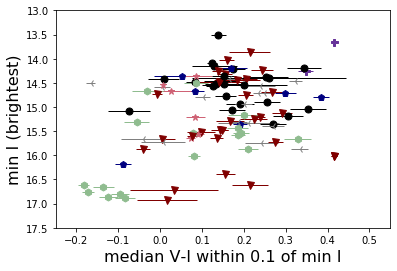

In [138]:
#min (brightest); using 0.1 brightest mag
typecm(bright=True,one=False)
plt.xlabel('median V-I within 0.1 of min I',fontsize=16)
plt.ylabel('min I (brightest)',fontsize=16)
plt.ylim(17.5,13) #cut out a few type 6
plt.xlim(-.25,.55)

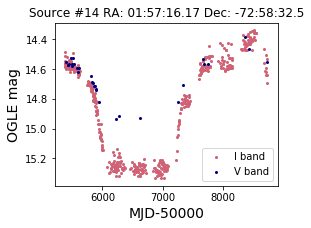

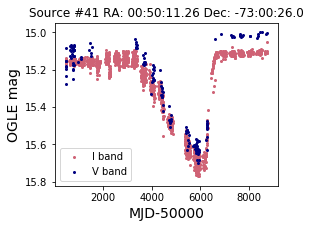

In [87]:
#two type 2 sources that are bluer at brightest point than type 1
#41 shows: maybe don't do absolute brightest?
plot(14) #makes sense since color generally shows this is more like a type 1
plot(41)
#although using third brightest below moves 14, not 41

empty file for OIII I
nan
empty file for OII I
empty file for OIII I
nan
nan


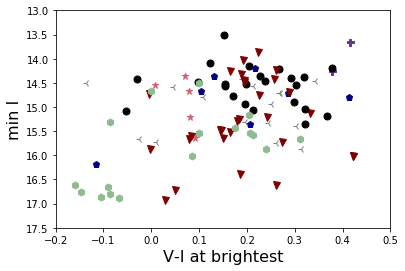

In [136]:
#min (brightest); using absolute brightest point
#see note about red type 2s above
typecm(bright=True,one=True,num=1) #change num to not use absolute brightest
plt.xlabel('V-I at brightest',fontsize=16)
plt.ylabel('min I',fontsize=16)
plt.ylim(17.5,13) #cut out a few type 6
plt.xlim(-.2,.5)
# plt.legend(loc='upper left')
# sf('mincolormag')

empty file for OIII I
nan
empty file for OII I
empty file for OIII I
nan
nan


(17.5, 13.8)

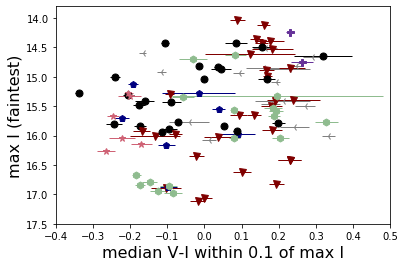

In [137]:
#max from colormag
#more overlap between types 1 and 2 at faint values
typecm(bright=False,one=False)
plt.xlabel('median V-I within 0.1 of max I',fontsize=16)
plt.ylabel('max I (faintest)',fontsize=16)
plt.xlim(-.4,.5)
plt.ylim(17.5,13.8)

empty file for OIII I
nan
empty file for OII I
empty file for OIII I
nan
nan


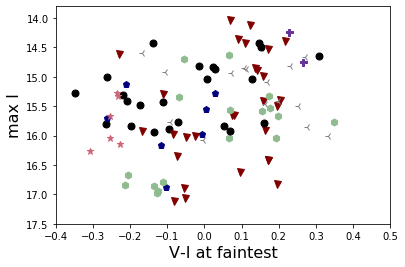

In [135]:
#absolute max from colormag
#interesting comparison between types 1 and 4
typecm(bright=False,one=True,num=1)
plt.xlabel('V-I at faintest',fontsize=16)
plt.ylabel('max I',fontsize=16)
plt.xlim(-.4,.5)
plt.ylim(17.5,13.8)
# sf('maxcolormag')

empty file for OIII I
empty file for OII I


(0, 1.3)

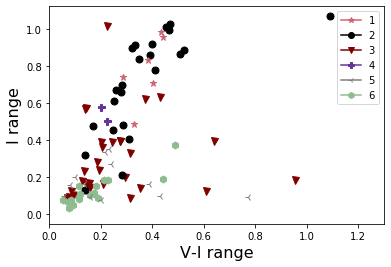

In [101]:
#last one: do V-I and I ranges (but could edit to not use absolute in case spurious points)
#mean not meaningful enough -- so not for final
#loop through and scatter; color based on type
lab = [False]*6 #turn to true once labeled
# labels = np.arange(1,7) 
colors = [pink,'black','maroon','rebeccapurple','grey','darkseagreen']
markers = ['*','o','v','P','3','h']
ims = []#list of mean I values
for s in range(len(alls)):
    row = alls.iloc[s]
    src = int(row['src_n'])
    try:
        typ = int(row['type'])
        #redirect types since not changed yet
        #careful if changed to final types in table
        if typ == 4 and src != 60 and src != 63: typ = 3
        elif typ == 3: typ = 2
        elif typ == 5: typ = 3
        elif typ == 6: typ = 5
        elif typ == 7: typ = 6
        #get LC
        try:iband,vband = o.getIV(src,cross,stack=True)
        except:iband,vband = o.getIV(src,cross2,mlist=mlist2,stack=True) 
        #interpolate iband
        interp = o.colormag(iband,vband,plot=False,retint=True,printcorr=False)
        vi = vband['V mag'] - interp
        #grab color and marker based on type
        color = colors[typ-1]; marker = markers[typ-1]
        if lab[typ-1]: #if already used
            #scatter the point with errorbars
            plt.errorbar(np.nanmax(vi)-np.nanmin(vi),np.nanmax(interp)-np.nanmin(interp),color=color,marker=marker,linestyle='none',elinewidth=1,markersize=7)
        if not lab[typ-1]:
            label = str(typ)
            plt.errorbar(np.nanmax(vi)-np.nanmin(vi),np.nanmax(interp)-np.nanmin(interp),color=color,marker=marker,linestyle='none',elinewidth=1,markersize=7,label=label)
            lab[typ-1] = True #now set bool to False to not label again
        #add I mean to help flip axes after loop
        ims.append(imean)
    except:'skipping transitions for now'
# plt.legend()
#overwrite legend
legend_elements = [Line2D([0], [0], color=colors[0],marker=markers[0], label='1'),
                   Line2D([0], [0], color=colors[1],marker=markers[1], label='2'),
                  Line2D([0], [0], color=colors[2],marker=markers[2], label='3'),
                  Line2D([0], [0], color=colors[3],marker=markers[3], label='4'),
                  Line2D([0], [0], color=colors[4],marker=markers[4], label='5'),
                  Line2D([0], [0], color=colors[5],marker=markers[5], label='6')]
plt.legend(handles=legend_elements)

#flip I band axes    
# plt.ylim(np.max(ims)+.1,np.min(ims)-.1)
plt.xlabel('V-I range',fontsize=16)
plt.ylabel('I range',fontsize=16) #interpolated I
# plt.ylim(17.5,13.5)
# plt.xlim(-.35,.5)
plt.xlim(0,1.3)

empty file for OIII I
empty file for OII I


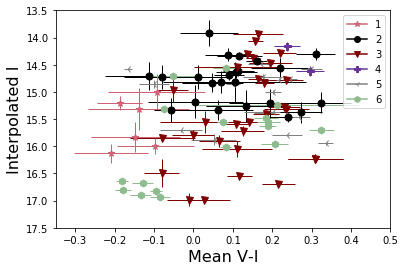

In [94]:
#mean not meaningful enough -- so not for final
#loop through and scatter; color based on type
lab = [False]*6 #turn to true once labeled
# labels = np.arange(1,7) 
colors = [pink,'black','maroon','rebeccapurple','grey','darkseagreen']
markers = ['*','o','v','P','3','h']
ims = []#list of mean I values
for s in range(len(alls)):
    row = alls.iloc[s]
    src = int(row['src_n'])
    try:
        typ = int(row['type'])
        #redirect types since not changed yet
        #careful if changed to final types in table
        if typ == 4 and src != 60 and src != 63: typ = 3
        elif typ == 3: typ = 2
        elif typ == 5: typ = 3
        elif typ == 6: typ = 5
        elif typ == 7: typ = 6
        #get LC
        try:iband,vband = o.getIV(src,cross,stack=True)
        except:iband,vband = o.getIV(src,cross2,mlist=mlist2,stack=True) 
        #interpolate iband
        interp = o.colormag(iband,vband,plot=False,retint=True,printcorr=False)
        vi = vband['V mag'] - interp
        vimean = np.mean(vi)
        vistd = np.std(vi)
        imean = np.mean(interp) #just using interpolated I band for now
        istd = np.std(interp)
        #grab color and marker based on type
        color = colors[typ-1]; marker = markers[typ-1]
        if lab[typ-1]: #if already used
            #scatter the point with errorbars
            plt.errorbar(vimean,imean,color=color,marker=marker,linestyle='none',yerr=istd,xerr=vistd,elinewidth=1,markersize=7)
        if not lab[typ-1]:
            label = str(typ)
            plt.errorbar(vimean,imean,color=color,marker=marker,linestyle='none',yerr=istd,xerr=vistd,elinewidth=1,markersize=7,label=label)
            lab[typ-1] = True #now set bool to False to not label again
        #add I mean to help flip axes after loop
        ims.append(imean)
    except:'skipping transitions for now'
# plt.legend()
#overwrite legend
legend_elements = [Line2D([0], [0], color=colors[0],marker=markers[0], label='1'),
                   Line2D([0], [0], color=colors[1],marker=markers[1], label='2'),
                  Line2D([0], [0], color=colors[2],marker=markers[2], label='3'),
                  Line2D([0], [0], color=colors[3],marker=markers[3], label='4'),
                  Line2D([0], [0], color=colors[4],marker=markers[4], label='5'),
                  Line2D([0], [0], color=colors[5],marker=markers[5], label='6')]
plt.legend(handles=legend_elements)

#flip I band axes    
plt.ylim(np.max(ims)+.1,np.min(ims)-.1)
plt.xlabel('Mean V-I',fontsize=16)
plt.ylabel('Interpolated I',fontsize=16)
sf('fullcm_woutliers')
plt.ylim(17.5,13.5)
plt.xlim(-.35,.5)
sf('fullcm_nooutliers')

In [30]:
type1 = o.gettype(alls,num='1')
type2 = o.gettype(alls,num='2')+o.gettype(alls,num='3')

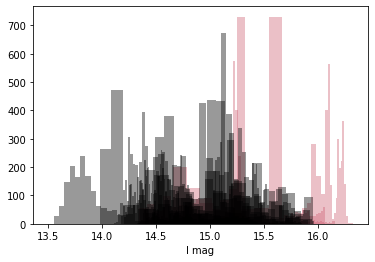

In [36]:
#histograms of all I band values for each type
for t in type1:
    try:iband,vband = o.getIV(t,cross,stack=True)
    except:iband,vband = o.getIV(t,cross2,mlist=mlist2,stack=True) 
    sb.distplot(iband['I mag'],kde=False,color=pink)
for t in type2:
    try:iband,vband = o.getIV(t,cross,stack=True)
    except:iband,vband = o.getIV(t,cross2,mlist=mlist2,stack=True) 
    sb.distplot(iband['I mag'],kde=False,color='black')

nothing jumping out as being significant in the histogram above

# Color-Mag Galleries

In [3]:
#old types besides 4 so rename
type1 = o.gettype(alls,num='1')
type2 = o.gettype(alls,num='2')
type3 = o.gettype(alls,num='3')
type4 = [60,63]
type5 = o.gettype(alls,num='5')+[5, 6, 9, 10]
type6 = o.gettype(alls,num='6')
type7 = o.gettype(alls,num='7')

Text(0.5, 0.98, 'Type 1 Source Color-Mag')

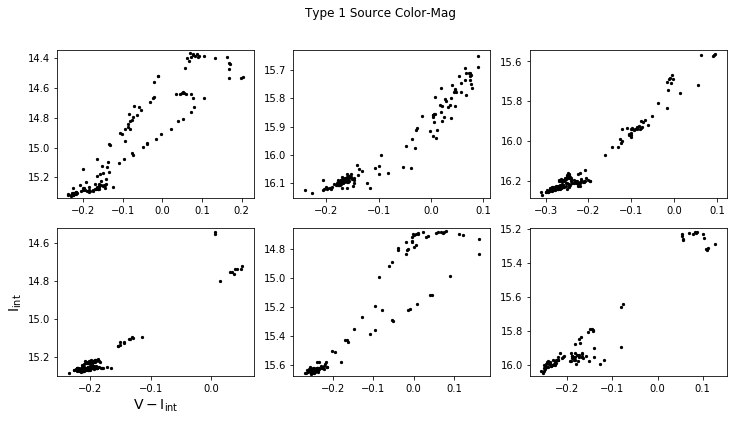

In [3]:
#loops!
fig = plt.figure(figsize=(12,6))
i = 1
for t in type1:
    try:iband,vband = o.getIV(t,cross,both=True,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=False)
    except:iband,vband = o.getIV(t,cross2,both=True,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=False)
    #color-mag
    interp = o.colormag(iband,vband,plot=False,printcorr=False,retint=True,ctime=True,cmap='viridis',both=True,save=False,file='')
    ax = fig.add_subplot(2,3,i)
    ax.scatter(vband['V mag']-interp,interp,color='black',s=5)
    maxi,mini = np.max(interp),np.min(interp)
    ax.set_ylim(maxi+.02,mini-.02)
    if i == 4:
        ax.set_ylabel('$\mathrm{I_{int}}$',fontsize=14)
        ax.set_xlabel('$\mathrm{V-I_{int}}$',fontsize=14)

    i+=1
fig.suptitle('Type 1 Source Color-Mag')
# sf('type1cm')

In [4]:
type1

[15, 48, 55, 126, 128, 132]

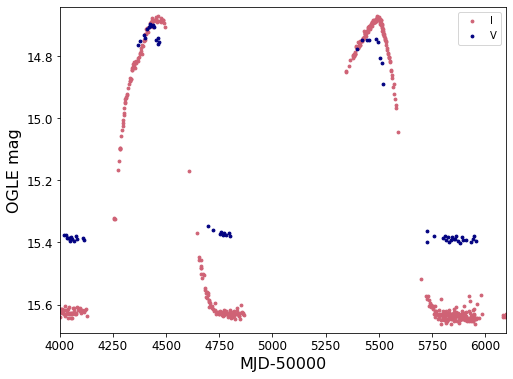

In [31]:
#I and V without different scales
fig,ax = plt.subplots(1,1,figsize=(8,6))
iband,vband = o.getIV(128,cross2,mlist=mlist2,stack=True)
interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
ax.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=8,label='I')
maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
ax.set_ylim(maxi+.02,mini-.02)

ax.scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=8,label='V')
# maxi,mini = np.max(vband['V mag']),np.min(vband['V mag'])
# ax1.set_ylim(maxi+.02,mini-.02)
ax.set_xlim(4000,6100)
ax.set_xlabel('MJD-50000',fontsize=16)
ax.set_ylabel('OGLE mag',fontsize=16)
ax.legend()
ax.tick_params(labelsize=12)
# sf('example_loopvi')

In [ ]:
def carrow(vband,interp,retvect=False,fs=(6,4)):
    '''Add option to first get LCs and interpolated I'''
    vi = vband['V mag']-interp
    plt.figure(figsize=fs)
    plt.scatter(vi,interp,color=pink)
    #vectors
    yvect = interp[1:]-interp[:-1]
    xvect = vi[1:]-vi[:-1]
    plt.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='darkseagreen',alpha=0.5)
    #flip I mag axis
    maxi,mini = np.max(interp),np.min(interp)
    plt.ylim(maxi+.02,mini-.02)
    plt.ylabel('I mag',fontsize=13)
    plt.xlabel('V-I',fontsize=13)
    if retvect: return xvect,yvect

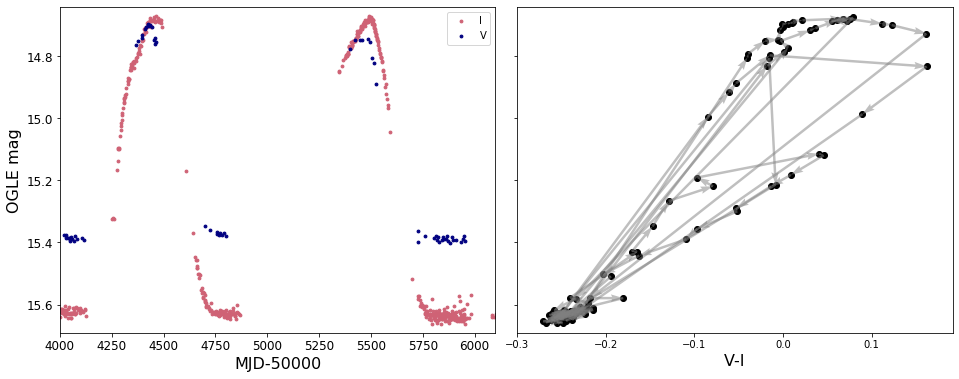

In [61]:
#now with subplots showing corresponding cm
fig,(ax,ax1) = plt.subplots(1,2,figsize=(16,6),sharey=True)
fig.subplots_adjust(wspace=0.05)
iband,vband = o.getIV(128,cross2,mlist=mlist2,stack=True)
interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
ax.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=8,label='I')
maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
ax.set_ylim(maxi+.02,mini-.02)

ax.scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=8,label='V')
# maxi,mini = np.max(vband['V mag']),np.min(vband['V mag'])
# ax1.set_ylim(maxi+.02,mini-.02)
ax.set_xlim(4000,6100)
ax.set_xlabel('MJD-50000',fontsize=16)
ax.set_ylabel('OGLE mag',fontsize=16)
ax.legend()
ax.tick_params(labelsize=12)
#plot color mag from this part
ib = iband[iband['MJD-50000']>4000];ib = ib[ib['MJD-50000']<6100]
vb = vband[vband['MJD-50000']>4000];vb = vb[vb['MJD-50000']<6100]
#new int
inte = o.colormag(ib,vb,retint=True,printcorr=False,plot=False)
vi = vband['V mag']-interp
# im = ax1.scatter(vb['V mag']-inte,inte,color='black')#c=vb['MJD-50000'],cmap='Purples') #to just have color mag from the part of LC shown
im = ax1.scatter(vi,interp,color='black')#c=vb['MJD-50000'],cmap='Purples')
yvect = interp[1:]-interp[:-1]
xvect = vi[1:]-vi[:-1]
ax1.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.5)
# ax1.set_ylim(maxi+.02,mini-.02)
# fig.colorbar(im)
#add arrows in time
ax1.set_xlabel('V-I',fontsize=16)
# sf('loopivsubplots')

In [28]:
#example of I with twinx V-I vs. time to show loop origin
# fig,ax = plt.subplots(1,1,figsize=(8,6))
# iband,vband = o.getIV(128,cross2,mlist=mlist2,stack=True)
# interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
# ax.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=6)
# maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
# ax.set_ylim(maxi+.02,mini-.02)
# ax1 = ax.twinx()
# ax1.tick_params(axis='y', labelcolor='navy')
# ax.tick_params(axis='y', labelcolor=pink)

# ax1.scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=6)
# maxi,mini = np.max(vband['V mag']),np.min(vband['V mag'])
# ax1.set_ylim(maxi+.02,mini-.02)
# ax.set_xlim(4000,6100)
# ax.set_xlabel('MJD-50000',fontsize=16)
# ax.set_ylabel('I mag',fontsize=16)
# ax1.set_ylabel('V mag',fontsize=16)

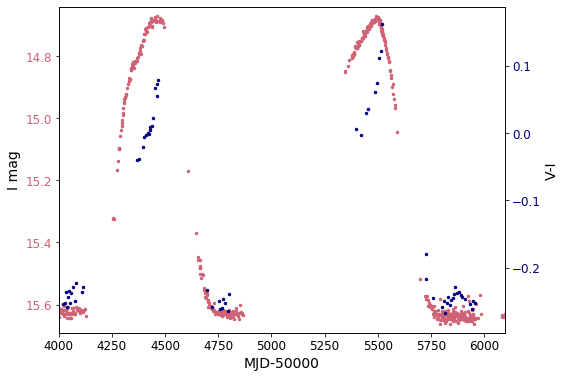

In [32]:
#make color and V version and decide which is better
#also try out showing the corresponding loop and direction
fig,ax = plt.subplots(1,1,figsize=(8,6))
iband,vband = o.getIV(128,cross2,mlist=mlist2,stack=True)
interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
ax.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=6)
maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
ax.set_ylim(maxi+.02,mini-.02)
ax1 = ax.twinx()
ax1.tick_params(axis='y', labelcolor='navy')
ax.tick_params(axis='y', labelcolor=pink)

ax1.scatter(vband['MJD-50000'],vband['V mag']-interp,color='navy',s=6)
ax.set_xlim(4000,6100)
ax.set_xlabel('MJD-50000',fontsize=14)
ax.set_ylabel('I mag',fontsize=14)
ax1.set_ylabel('V-I',fontsize=14)
ax.tick_params(labelsize=12)
ax1.tick_params(labelsize=12)
# sf('example_loopiv-i')

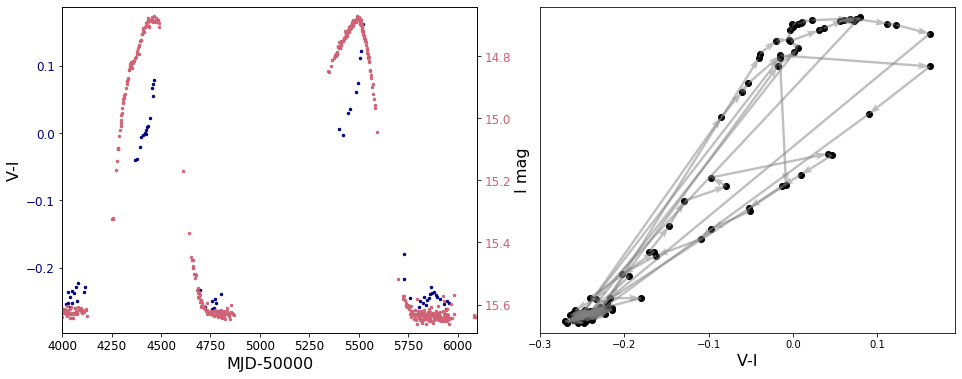

In [62]:
#subplot version
fig,(ax1,ax2) = plt.subplots(1,2,figsize=(16,6))
fig.subplots_adjust(wspace=0.15)
iband,vband = o.getIV(128,cross2,mlist=mlist2,stack=True)
interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
ax = ax1.twinx()
ax.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=6)
maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
ax.set_ylim(maxi+.02,mini-.02)
ax1.tick_params(axis='y', labelcolor='navy')
ax.tick_params(axis='y', labelcolor=pink)

ax1.scatter(vband['MJD-50000'],vband['V mag']-interp,color='navy',s=6)
ax.set_xlim(4000,6100)
ax.set_xlabel('MJD-50000',fontsize=16)
ax.set_ylabel('I mag',fontsize=16)
ax1.set_ylabel('V-I',fontsize=16)
ax.tick_params(labelsize=12)
ax1.tick_params(labelsize=12)

#color-mag
ax2.set_ylim(maxi+.02,mini-.02)
vi = vband['V mag']-interp
im = ax2.scatter(vi,interp,color='black')#c=vb['MJD-50000'],cmap='Purples')
yvect = interp[1:]-interp[:-1]
xvect = vi[1:]-vi[:-1]
ax2.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.5)
ax2.set_yticks([])
ax1.set_xlabel('MJD-50000',fontsize=16)
ax2.set_xlabel('V-I',fontsize=16)
# sf('loopv-isubplots')

In [36]:
a = type2+type3
a[14]

16

Text(0.5, 0.98, 'Type 2 Source Color-Mag')

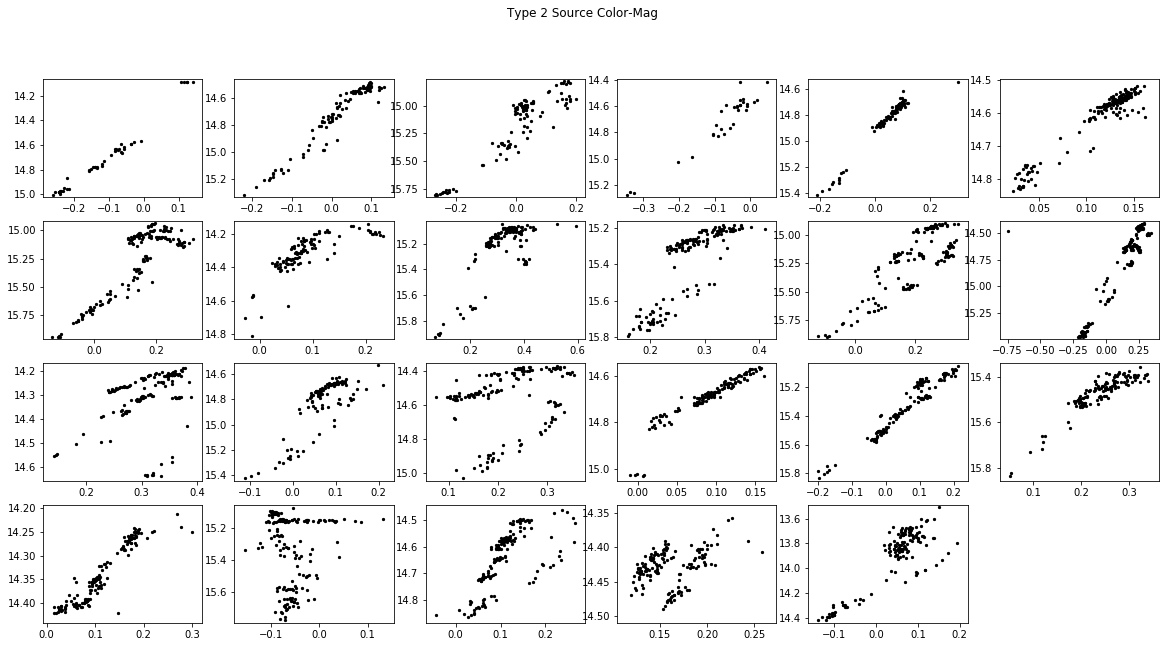

In [24]:
fig = plt.figure(figsize=(20,10))
i = 1
for t in type2+type3:
    try:iband,vband = o.getIV(t,cross,both=True,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=False)
    except:iband,vband = o.getIV(t,cross2,both=True,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=False)
    #color-mag
    interp = o.colormag(iband,vband,plot=False,printcorr=False,retint=True,ctime=True,cmap='viridis',both=True,save=False,file='')
    ax = fig.add_subplot(4,6,i)
    ax.scatter(vband['V mag']-interp,interp,color='black',s=5)
    maxi,mini = np.max(interp),np.min(interp)
    ax.set_ylim(maxi+.02,mini-.02)
#     if i == 4:
#         ax.set_ylabel('$\mathrm{I_{int}}$',fontsize=14)
#         ax.set_xlabel('$\mathrm{V-I_{int}}$',fontsize=14)

    i+=1
fig.suptitle('Type 2 Source Color-Mag')
# sf('type1cm')

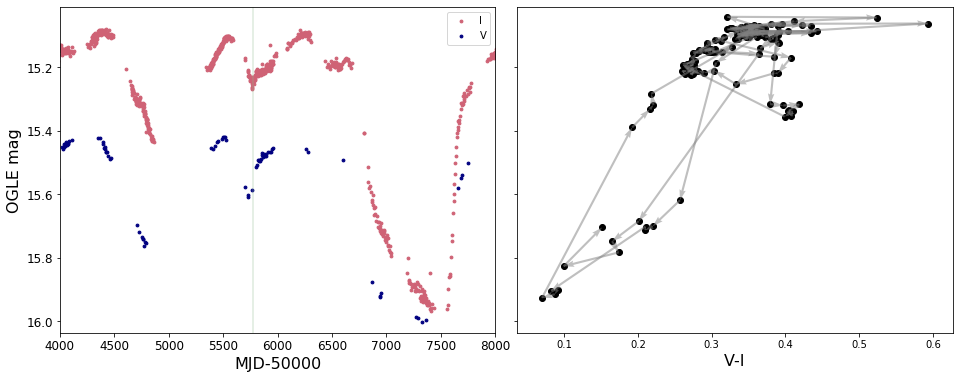

In [24]:
#do similar zoom-in with one of these sources
fig,(ax,ax1) = plt.subplots(1,2,figsize=(16,6),sharey=True)
fig.subplots_adjust(wspace=0.05)
iband,vband = o.getIV(type2[8],cross2,mlist=mlist2,stack=True)
interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
ax.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=8,label='I')
maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
ax.set_ylim(maxi+.07,mini-.02)

ax.scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=8,label='V')
# maxi,mini = np.max(vband['V mag']),np.min(vband['V mag'])
# ax1.set_ylim(maxi+.02,mini-.02)
ax.set_xlim(4000,8000)
ax.set_xlabel('MJD-50000',fontsize=16)
ax.set_ylabel('OGLE mag',fontsize=16)
ax.legend()
ax.tick_params(labelsize=12)

#new int
vi = vband['V mag']-interp

im = ax1.scatter(vi,interp,color='black')#c=vb['MJD-50000'],cmap='Purples')
yvect = interp[1:]-interp[:-1]
xvect = vi[1:]-vi[:-1]

ax1.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.5)
# ax1.set_ylim(maxi+.02,mini-.02)
#add arrows in time
ax1.set_xlabel('V-I',fontsize=16)
# sf('loopivsubplots')
ax.axvline(5770,color='darkseagreen',alpha=0.3)
# sf('type2loopsubplots')


#option to just show color-mag from part of LC shown
# ib = iband[iband['MJD-50000']>4000];ib = ib[ib['MJD-50000']<8000]
# vb = vband[vband['MJD-50000']>4000];vb = vb[vb['MJD-50000']<8000]
# inte = o.colormag(ib,vb,retint=True,printcorr=False,plot=False)
# vi = vb['V mag']-inte
# im = ax1.scatter(vi,inte,color='black')
# yvect = inte[1:]-inte[:-1]
# xvect = vi[1:]-vi[:-1]
# ax1.quiver(vi[:-1],inte[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.5)


Text(0.5, 0, 'V-I')

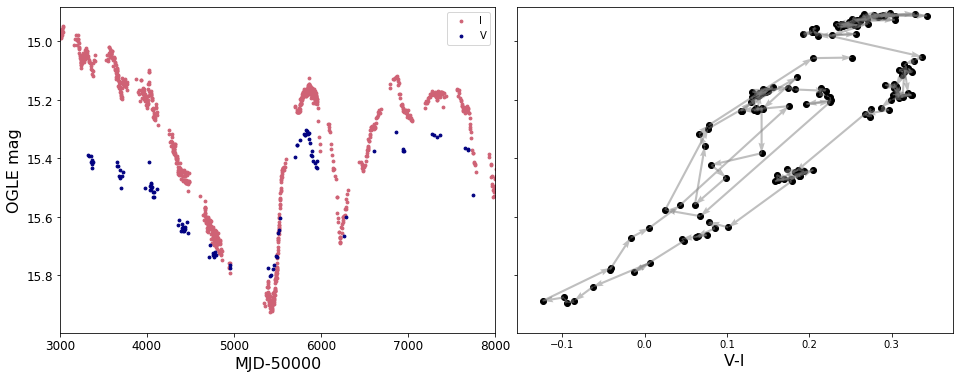

In [139]:
#similar for another type 2 source?
fig,(ax,ax1) = plt.subplots(1,2,figsize=(16,6),sharey=True)
fig.subplots_adjust(wspace=0.05)
iband,vband = o.getIV(type2[10],cross2,mlist=mlist2,stack=True)
interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
ax.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=8,label='I')
maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
ax.set_ylim(maxi+.07,mini-.02)

ax.scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=8,label='V')
# maxi,mini = np.max(vband['V mag']),np.min(vband['V mag'])
# ax1.set_ylim(maxi+.02,mini-.02)
ax.set_xlim(3000,8000)
ax.set_xlabel('MJD-50000',fontsize=16)
ax.set_ylabel('OGLE mag',fontsize=16)
ax.legend()
ax.tick_params(labelsize=12)
#plot color mag from this part
ib = iband[iband['MJD-50000']>4000];ib = ib[ib['MJD-50000']<6100]
vb = vband[vband['MJD-50000']>4000];vb = vb[vb['MJD-50000']<6100]
#new int
inte = o.colormag(ib,vb,retint=True,printcorr=False,plot=False)
vi = vband['V mag']-interp
# im = ax1.scatter(vb['V mag']-inte,inte,color='black')#c=vb['MJD-50000'],cmap='Purples') #to just have color mag from the part of LC shown
im = ax1.scatter(vi,interp,color='black')#c=vb['MJD-50000'],cmap='Purples')
yvect = interp[1:]-interp[:-1]
xvect = vi[1:]-vi[:-1]
ax1.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.5)
# ax1.set_ylim(maxi+.02,mini-.02)
# fig.colorbar(im)
#add arrows in time
ax1.set_xlabel('V-I',fontsize=16)
# sf('loopivsubplots')

In [30]:
len(type2)

13

Text(0.5, 0, 'V-I')

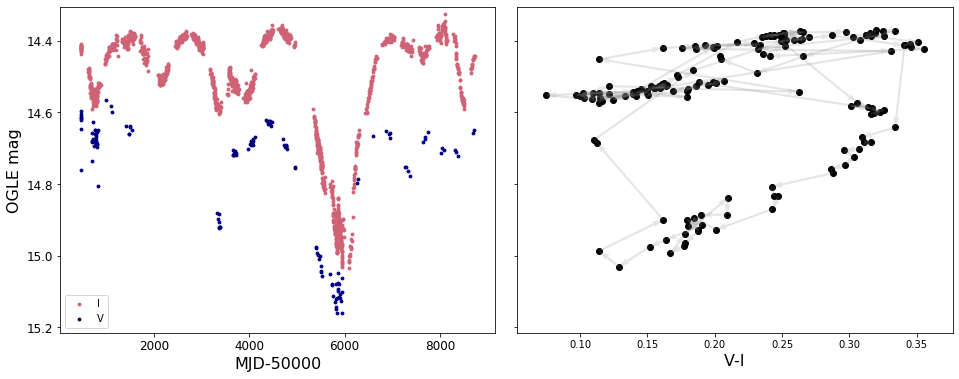

In [51]:
#one more example
fig,(ax,ax1) = plt.subplots(1,2,figsize=(16,6),sharey=True)
fig.subplots_adjust(wspace=0.05)
iband,vband = o.getIV(16,cross,mlist=mlist1,stack=True)
interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
ax.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=8,label='I')
maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
ax.set_ylim(maxi+.18,mini-.02)

ax.scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=8,label='V')
# maxi,mini = np.max(vband['V mag']),np.min(vband['V mag'])
# ax1.set_ylim(maxi+.02,mini-.02)
# ax.set_xlim(3000,8000)
ax.set_xlabel('MJD-50000',fontsize=16)
ax.set_ylabel('OGLE mag',fontsize=16)
ax.legend()
ax.tick_params(labelsize=12)
#plot color mag from this part
ib = iband[iband['MJD-50000']>4000];ib = ib[ib['MJD-50000']<6100]
vb = vband[vband['MJD-50000']>4000];vb = vb[vb['MJD-50000']<6100]
#new int
inte = o.colormag(ib,vb,retint=True,printcorr=False,plot=False)
vi = vband['V mag']-interp
# im = ax1.scatter(vb['V mag']-inte,inte,color='black')#c=vb['MJD-50000'],cmap='Purples') #to just have color mag from the part of LC shown
im = ax1.scatter(vi,interp,color='black')#c=vb['MJD-50000'],cmap='Purples')
yvect = interp[1:]-interp[:-1]
xvect = vi[1:]-vi[:-1]
ax1.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.2)
# ax1.set_ylim(maxi+.02,mini-.02)
# fig.colorbar(im)
#add arrows in time
ax1.set_xlabel('V-I',fontsize=16)
# sf('type2loopsubplots2')


often lack of loop in type 2 seems to be possibly just an issue of coverage

Text(0.5, 0, 'V-I')

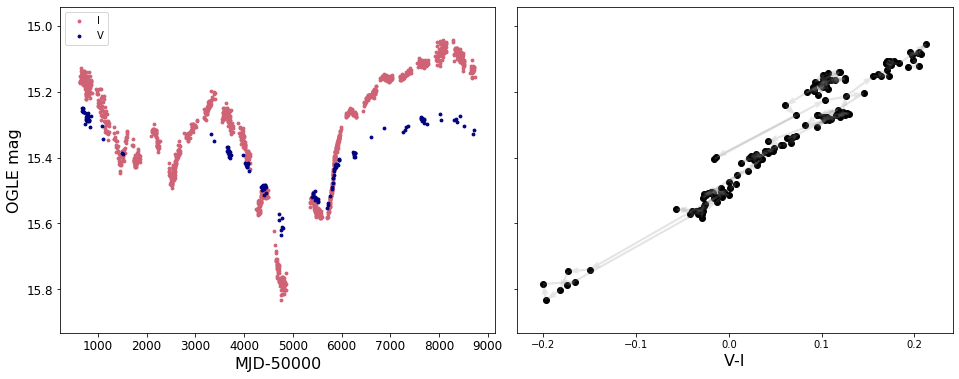

In [73]:
#looking at other members of type 2/3 here
fig,(ax,ax1) = plt.subplots(1,2,figsize=(16,6),sharey=True)
fig.subplots_adjust(wspace=0.05)
iband,vband = o.getIV(type3[3],cross,mlist=mlist1,stack=True)
interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
ax.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=8,label='I')
maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
ax.set_ylim(maxi+.1,mini-.1)

ax.scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=8,label='V')
# maxi,mini = np.max(vband['V mag']),np.min(vband['V mag'])
# ax1.set_ylim(maxi+.02,mini-.02)
# ax.set_xlim(3000,8000)
ax.set_xlabel('MJD-50000',fontsize=16)
ax.set_ylabel('OGLE mag',fontsize=16)
ax.legend()
ax.tick_params(labelsize=12)
#plot color mag from this part
ib = iband[iband['MJD-50000']>4000];ib = ib[ib['MJD-50000']<6100]
vb = vband[vband['MJD-50000']>4000];vb = vb[vb['MJD-50000']<6100]
#new int
inte = o.colormag(ib,vb,retint=True,printcorr=False,plot=False)
vi = vband['V mag']-interp
# im = ax1.scatter(vb['V mag']-inte,inte,color='black')#c=vb['MJD-50000'],cmap='Purples') #to just have color mag from the part of LC shown
im = ax1.scatter(vi,interp,color='black')#c=vb['MJD-50000'],cmap='Purples')
yvect = interp[1:]-interp[:-1]
xvect = vi[1:]-vi[:-1]
ax1.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.2)
# ax1.set_ylim(maxi+.02,mini-.02)
# fig.colorbar(im)
#add arrows in time
ax1.set_xlabel('V-I',fontsize=16)
# sf('type2diffsubplots')

Text(0.5, 0.98, 'Type 3 Source Color-Mag')

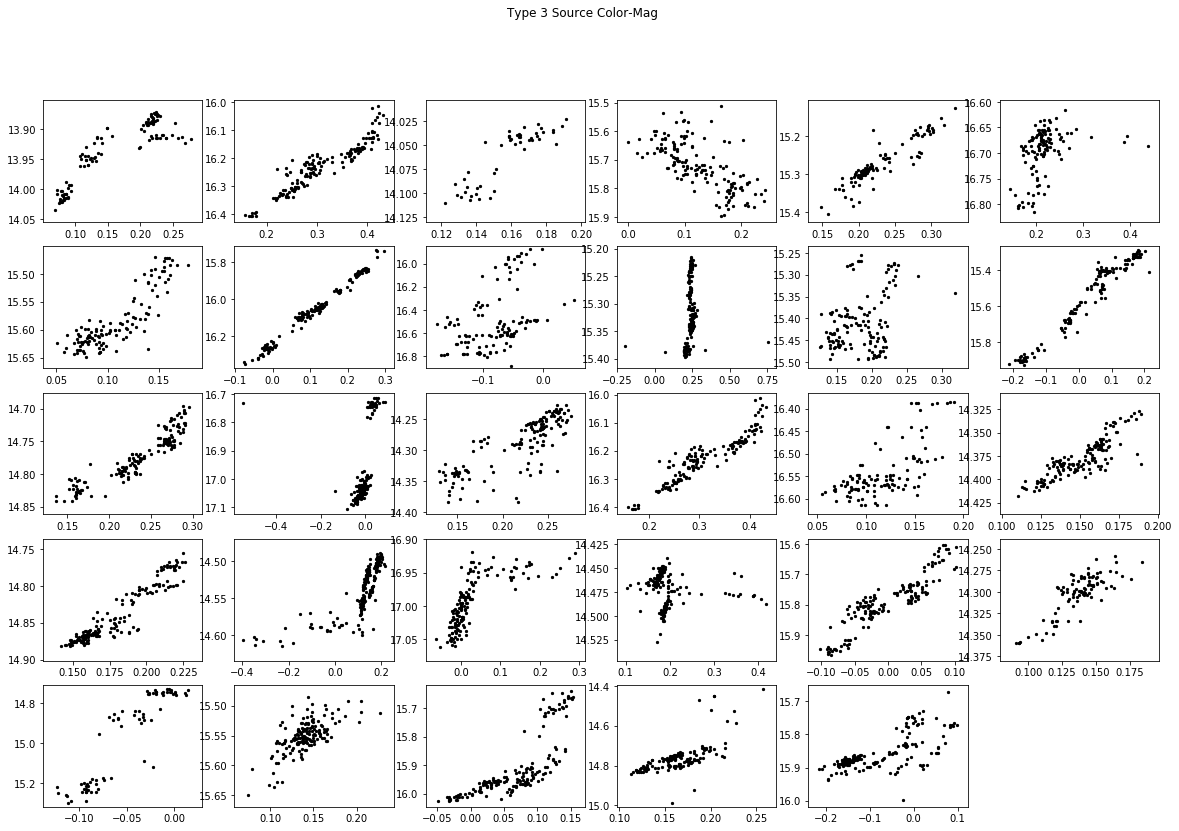

In [26]:
fig = plt.figure(figsize=(20,13))
i = 1
for t in type5:
    try:iband,vband = o.getIV(t,cross,both=True,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=False)
    except:iband,vband = o.getIV(t,cross2,both=True,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=False)
    #color-mag
    interp = o.colormag(iband,vband,plot=False,printcorr=False,retint=True,ctime=True,cmap='viridis',both=True,save=False,file='')
    ax = fig.add_subplot(5,6,i)
    ax.scatter(vband['V mag']-interp,interp,color='black',s=5)
    maxi,mini = np.max(interp),np.min(interp)
    ax.set_ylim(maxi+.02,mini-.02)
#     if i == 4:
#         ax.set_ylabel('$\mathrm{I_{int}}$',fontsize=14)
#         ax.set_xlabel('$\mathrm{V-I_{int}}$',fontsize=14)

    i+=1
fig.suptitle('Type 3 Source Color-Mag')
# sf('type1cm')

some diversity but definitely simpler
- type 4 just linear correlation with some scatter

In [7]:
len(type6)

16

empty file for OIII I


Text(0.5, 0.98, 'Type 5 Source Color-Mag')

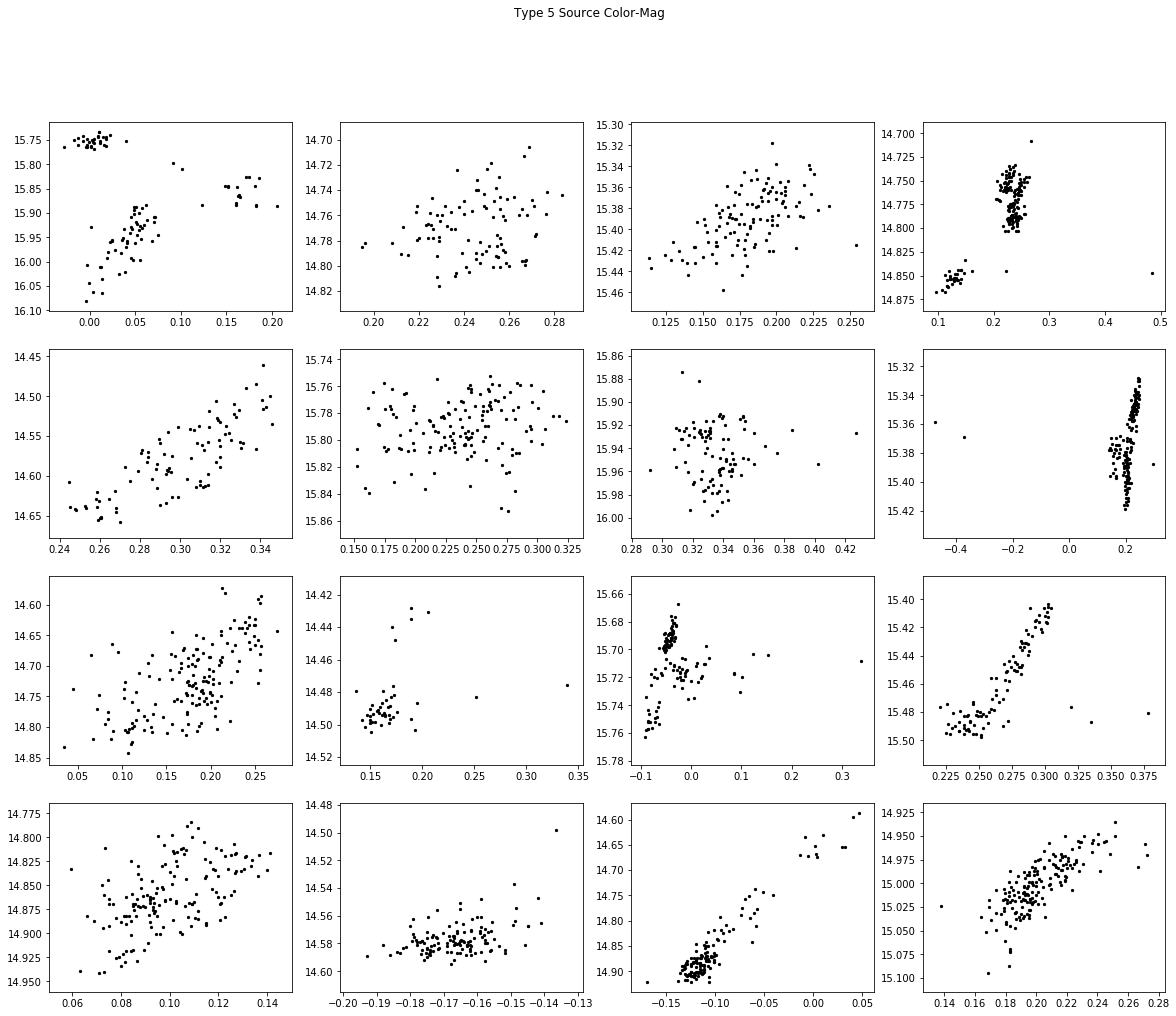

In [8]:
fig = plt.figure(figsize=(20,16))
i = 1
for t in type6:
    try:iband,vband = o.getIV(t,cross,both=True,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=False)
    except:iband,vband = o.getIV(t,cross2,both=True,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=False)
    #color-mag
    interp = o.colormag(iband,vband,plot=False,printcorr=False,retint=True,ctime=True,cmap='viridis',both=True,save=False,file='')
    ax = fig.add_subplot(4,4,i)
    ax.scatter(vband['V mag']-interp,interp,color='black',s=5)
    maxi,mini = np.max(interp),np.min(interp)
    ax.set_ylim(maxi+.02,mini-.02)
#     if i == 4:
#         ax.set_ylabel('$\mathrm{I_{int}}$',fontsize=14)
#         ax.set_xlabel('$\mathrm{V-I_{int}}$',fontsize=14)

    i+=1
fig.suptitle('Type 5 Source Color-Mag')

empty file for OII I


Text(0.5, 0.98, 'Type 6 Source Color-Mag')

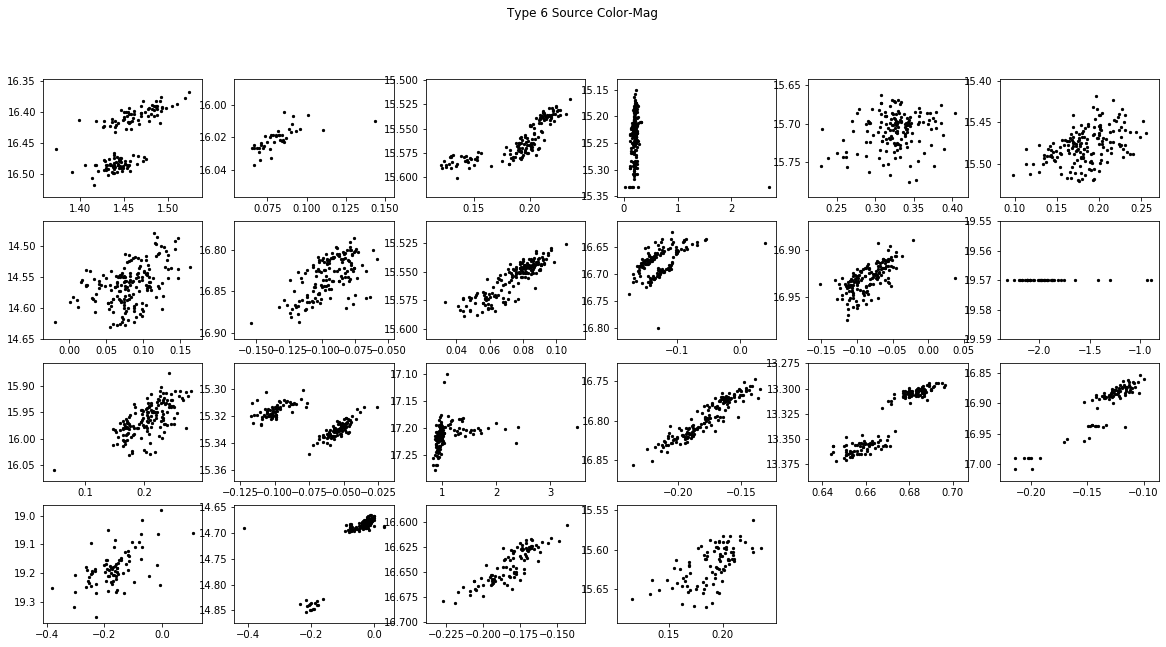

In [10]:
fig = plt.figure(figsize=(20,10))
i = 1
for t in type7:
    try:iband,vband = o.getIV(t,cross,both=True,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=False)
    except:iband,vband = o.getIV(t,cross2,both=True,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=False)
    #color-mag
    interp = o.colormag(iband,vband,plot=False,printcorr=False,retint=True,ctime=True,cmap='viridis',both=True,save=False,file='')
    ax = fig.add_subplot(4,6,i)
    ax.scatter(vband['V mag']-interp,interp,color='black',s=5)
    maxi,mini = np.max(interp),np.min(interp)
    ax.set_ylim(maxi+.02,mini-.02)
#     if i == 4:
#         ax.set_ylabel('$\mathrm{I_{int}}$',fontsize=14)
#         ax.set_xlabel('$\mathrm{V-I_{int}}$',fontsize=14)

    i+=1
fig.suptitle('Type 6 Source Color-Mag')

In [9]:
len(type7)

22

#### for sources with loops, print type
- do subdivisions correspond to different types (hypothesis: type 1 vs. type 2)

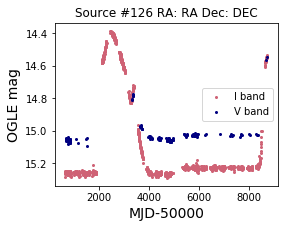

In [5]:
plot(126)

# Directly Compare Color at Base for Types 1 and 2

In [140]:
def basecolor(mag=0.05):
    '''plot color-mag near base for types 1 and 2
    mag: magnitude within max/min to use as base'''
    for t in type1:
        try:iband,vband = o.getIV(t,cross,stack=True)
        except:iband,vband = o.getIV(t,cross2,mlist=mlist2,stack=True) 
        #get interp
        interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
        vi = vband['V mag'] - interp
        #get faintest 0.05 mags
        vband['V-I'] = vi; vband['I'] = interp
        maxi = np.max(interp)
        faint = vband[vband['I']>maxi-mag]
        #now scatter I and V-I from faint
        plt.errorbar(np.mean(faint['V-I']),np.mean(faint['I']),yerr=np.std(faint['I']),xerr=np.std(faint['V-I']),color=pink,marker='*',ls='none')
    for t in type2+type3:
        try:iband,vband = o.getIV(t,cross,stack=True)
        except:iband,vband = o.getIV(t,cross2,mlist=mlist2,stack=True) 
        #get interp
        interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
        vi = vband['V mag'] - interp
        #get faintest 0.05 mags
        vband['V-I'] = vi; vband['I'] = interp
        mini = np.min(interp)
        bright = vband[vband['I']<mini+mag]
        #now scatter I and V-I from faint
        plt.errorbar(np.mean(bright['V-I']),np.mean(bright['I']),yerr=np.std(bright['I']),xerr=np.std(bright['V-I']),color='black',marker='o',ls='none') 
    plt.ylabel('I mag',fontsize=15)
    plt.xlabel('V-I',fontsize=15)

(13, 16.5)

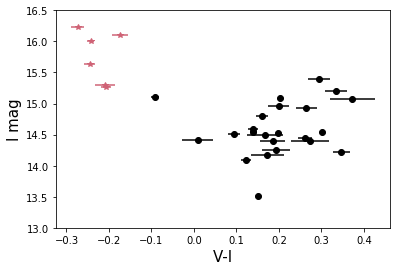

In [14]:
basecolor()
plt.ylim(13,16.5)

In [5]:
type6_out = [25, 28, 36, 38, 45, 56, 61, 65, 72, 79, 82, 96, 111, 119, 133]
type7_out = [8, 42, 47, 49, 58, 59, 64, 68, 69, 71, 76, 81, 93, 100, 105, 114, 129, 138, 139, 141]

empty file for OIII I


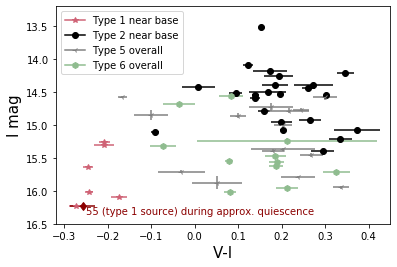

In [9]:
#now compare to type 5 to see if that tells what direction they'll go in
basecolor()
for t in type6_out:
    try:iband,vband = o.getIV(t,cross,stack=True)
    except:iband,vband = o.getIV(t,cross2,mlist=mlist2,stack=True) 
    #get interp
    interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
    vi = vband['V mag'] - interp
    #get faintest 0.05 mags
    vband['V-I'] = vi; vband['I'] = interp
    plt.errorbar(np.mean(vband['V-I']),np.mean(vband['I']),yerr=np.std(vband['I']),xerr=np.std(vband['V-I']),color='grey',marker='3',ls='none')
plt.ylim(16.5,13.2)
legend_elements = [Line2D([0], [0], color=pink,marker='*', label='Type 1 near base'),
                   Line2D([0], [0], color='black',marker='o', label='Type 2 near base'),
                  Line2D([0], [0], color='grey',marker='3', label='Type 5 overall'),
                  Line2D([0], [0], color='darkseagreen',marker='h', label='Type 6 overall')]
plt.legend(handles=legend_elements)
#add 55 just during quiescence
iband,vband = o.getIV(55,cross,stack=True)
interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
vi = vband['V mag'] - interp
#get faintest 0.05 mags
vband['V-I'] = vi; vband['I'] = interp
first = vband[vband['MJD-50000']<4700]#just first part, which is quiescent
plt.errorbar(np.mean(first['V-I']),np.mean(first['I']),yerr=np.std(first['I']),xerr=np.std(first['V-I']),color='darkred',marker='d',ls='none')
plt.text(-0.25,16.35,'55 (type 1 source) during approx. quiescence',color='darkred')

for t in type7_out:
    try:iband,vband = o.getIV(t,cross,stack=True,calib=True)
    except:iband,vband = o.getIV(t,cross2,mlist=mlist2,stack=True,calib=True) 
    #get interp
    interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
    vi = vband['V mag'] - interp
    #get faintest 0.05 mags
    vband['V-I'] = vi; vband['I'] = interp
    plt.errorbar(np.mean(vband['V-I']),np.mean(vband['I']),yerr=np.std(vband['I']),xerr=np.std(vband['V-I']),color='darkseagreen',marker='h',ls='none')
plt.xlim(-.32,.45)
# sf('basecolors')
#also add transitions

next: can add transition sources?

## color-mag slope vs. I band stdev but change 'slope' to ratio of ranges
-  not finished, I think

In [38]:
#go through sources and get I band range and V-I range (but drop at least one point on either end)
iranges = []
viranges = []
for s in alls['src_n']:
    try:
        try:iband,vband = o.getIV(s,cross,stack=True)
        except:iband,vband = o.getIV(s,cross2,mlist=mlist2,stack=True) 
        #get interp
        interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
        vi = vband['V mag'] - interp
        #sort iband mag (original or interp?)
        sorti = np.sort(interp)#np.sort(iband['I mag'])
        sortvi = np.sort(vi)
        ir = sorti[-3]-sorti[2] #I range (third point in each)
        vir = sortvi[-3]-sortvi[2]
        iranges.append(ir);viranges.append(vir)
    except: iranges.append(np.nan);viranges.append(np.nan)

empty file for OIII I
empty file for OII I
empty file for OIII I


(0, 0.6)

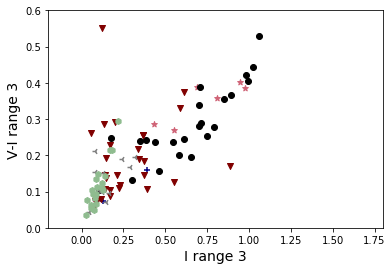

In [39]:
alls['I range 3'] = iranges
alls['V-I range 3'] = viranges
fulltplot(x='I range 3',y='V-I range 3',legend=False,tab=alls,
         tbool=[False,False,False,False,False,False,False])
#note that a few points cut out but I don't trust their ranges anyway
plt.xlim(-.2,1.8)
plt.ylim(0,.6)

(-0.02, 0.4)

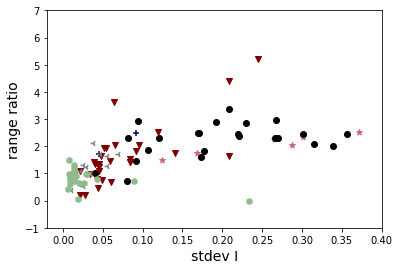

In [40]:
#but want ratio as if slope
#ratio is I/V-I???
#slightly different but same general answer whether or not interp
alls['range ratio'] = np.array(iranges)/viranges
fulltplot(x='stdev I',y='range ratio',legend=False,tab=alls,
         tbool=[False,False,False,False,False,False,False])
plt.ylim(-1,7)
plt.xlim(-.02,.4)

# Skew-Kurtosis 
- changing to indicate which sources have established periods from X-ray
- also try out subplots with examples based on different regions of plot

- **not finished**: some version with type 4s cropped out to be able to see the other sources better
    - one option: initial plot doesn't have all this detail

In [13]:
xlist = [7,31,37,11,13,6,27,2,3,12,44,49,56,60,9,23,36,54]

In [14]:
len(xlist)

18

In [ ]:
plot(77)

## two outliers at low negative skew and high kurtosis are the two sources in type 4 (60, 63)

### give each source an xlist two points (best from periodogram and established) and connect the points
- if connection not enough, they can get their own color or something

## to do: add points or decide what to do about points in original plot that used 'best period'

In [17]:
#for X-ray sources, separately calculate skew and kurtosis using X-ray period
xpf = pd.DataFrame(columns=['src_n','est','best','est skew','est kurt','best skew','best kurt'])
xpf['src_n'] = xlist
ests = []
bests = []
skews = []
kurts = []
bskews = []
bkurts = []
mskews = [] # if manual best period
mkurts = []
ms = []
for x in xlist:
    row = alls[alls['src_n']==x]
    est = float(row['est. period'])
    ests.append(est)
    #best = float(row['best auto det pd'])
    best = float(row['pf period'])
    bests.append(best)
    manual = float(row['best period'])
    ms.append(manual)
    try: iband = o.getIV(x,cross,mlist=mlist1,stack=True,both=False)
    except: iband = o.getIV(x,cross2,mlist=mlist2,stack=True,both=False)
    o.splinedetrend(iband)
    if est>300:det=False
    else: det=True
    mid,avg,err = o.meanphase(iband,est,16,det=True,med=False,double=True,stdev=True,sterr=True,divide=True)
    #get skew and kurtosis of avg
    skews.append(st.skew(avg,nan_policy='omit'));kurts.append(st.kurtosis(avg,nan_policy='omit'))
    mid,avg,err = o.meanphase(iband,best,16,det=True,med=False,double=True,stdev=True,sterr=True,divide=True)
    #get skew and kurtosis of avg
    bskews.append(st.skew(avg,nan_policy='omit'));bkurts.append(st.kurtosis(avg,nan_policy='omit'))
    #if best period
    if np.isnan(manual): mskews.append(np.nan);mkurts.append(np.nan)
    else:
        mid,avg,err = o.meanphase(iband,manual,16,det=True,med=False,double=True,stdev=True,sterr=True,divide=True)
        mskews.append(st.skew(avg,nan_policy='omit'));mkurts.append(st.kurtosis(avg,nan_policy='omit'))

In [18]:
xpf['est'] = ests
xpf['gram'] = bests
xpf['est skew'] = skews
xpf['est kurt'] = kurts
xpf['gram kurt'] = bkurts
xpf['gram skew'] = bskews
xpf['best kurt'] = mkurts
xpf['best skew'] = mskews
xpf['best'] = ms

### so question of whether or not to use detrended best when the period is above 200 days
- in the case of src 60, want to use
- confusion is over why the auto det pd is 350 (as expected from code as well), but then the skew, kurt are so extreme?
--> saved from different place??
- either way, may want to ultimately re-do the phase-folded values

['#161155','#2c22aa','#372ad5','#8880e6','#afaaee','#d7d4f7','#59938f','#3a5f5d','#609f9b'
                ,'#609f9b','#609f9b','#609f9b','#609f9b','#609f9b','#609f9b','#609f9b','#609f9b','#609f9b']

Text(-3.4, 10.6, 'type 4 sources (periods found manually)')

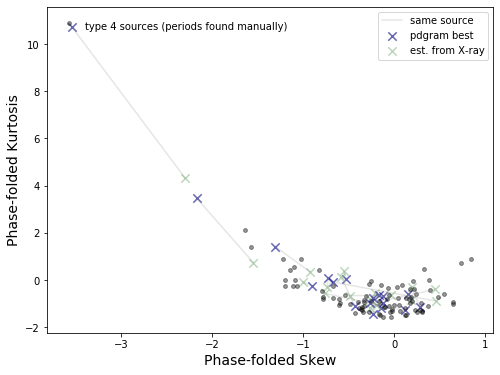

In [19]:
plt.figure(figsize=(8,6))
for s in range(len(alls)):
    row = alls.iloc[s]
    srcn = int(row['src_n'])
    if srcn not in xlist:
        plt.scatter(row['pf skew '],row['pf kurtosis'],color='black',alpha=0.4,marker='o',s=15)
    else:
        xrow = xpf[xpf['src_n']==srcn]
        if s==1: plt.scatter(row['pf skew '],row['pf kurtosis'],color='navy',alpha=0.6,marker='x',s=70,label='pdgram best')
        else:plt.scatter(row['pf skew '],row['pf kurtosis'],color='navy',alpha=0.6,marker='x',s=70)
        if s==1:plt.scatter(xrow['est skew'],xrow['est kurt'],color='darkseagreen',alpha=0.6,marker='x',s=70,label='est. from X-ray')
        else:plt.scatter(xrow['est skew'],xrow['est kurt'],color='darkseagreen',alpha=0.6,marker='x',s=70)
        if s==1:plt.plot([float(row['pf skew ']),float(xrow['est skew'])],[float(row['pf kurtosis']),float(xrow['est kurt'])],color='grey',alpha=0.2,label='same source')
        plt.plot([float(row['pf skew ']),float(xrow['est skew'])],[float(row['pf kurtosis']),float(xrow['est kurt'])],color='grey',alpha=0.2)
# plt.ylim(-2,4)
# plt.xlim(-2.5,1)
plt.ylabel('Phase-folded Kurtosis',fontsize=14)
plt.xlabel('Phase-folded Skew',fontsize=14)
# plt.text(-3.5,10,'periods for type 4 found manually')
plt.legend()
plt.text(-3.4,10.6,'type 4 sources (periods found manually)')
# sf('new_skewkurt')

## try out inset and subplots with associated profiles


In [76]:
xpf[xpf['gram skew']<-1]

src_n     est   best  est skew  est kurt  best skew  best kurt  \
13     60  390.00  393.0 -2.297143  4.315732   -3.53728  10.701834   
15     23  137.36    NaN -1.547559  0.728949        NaN        NaN   
16     36   68.54    NaN -0.926404  0.341440        NaN        NaN   

          gram  gram kurt  gram skew  
13  393.000000  10.701834  -3.537280  
15  137.916601   3.468811  -2.171697  
16   68.616612   1.414957  -1.307362

In [20]:
iband = o.getIV(23,cross,stack=True,both=False)

In [21]:
o.splinedetrend(iband)

In [22]:
prd = 137.916601
# prd = 137.36

mid23,avg23,err23 = o.meanphase(iband,prd,pbins=16,det=True,stdev=True,divide=True,sterr=True,double=True)

In [23]:
iband = o.getIV(6,cross,stack=True,both=False)
o.splinedetrend(iband)
prd = 17.13
# prd = 137.36

mid6,avg6,err6 = o.meanphase(iband,prd,pbins=16,det=True,stdev=True,divide=True,sterr=True,double=True)

In [60]:
xpf[xpf['src_n']==3]

src_n    est   best  est skew  est kurt  best skew  best kurt       gram  \
8      3  18.38  18.38 -0.272769 -0.823777  -0.272769  -0.823777  17.404354   

   gram kurt  gram skew  
8  -0.682829   0.187145

In [61]:
iband = o.getIV(3,cross,stack=True,both=False)
o.splinedetrend(iband)
est = 18.38
gram = 17.404354
mid3,avg3,err3 = o.meanphase(iband,est,pbins=16,det=True,stdev=True,divide=True,sterr=True,double=True)
mid3p,avg3p,err3p = o.meanphase(iband,gram,pbins=16,det=True,stdev=True,divide=True,sterr=True,double=True)

In [24]:
iband = o.getIV(2,cross,stack=True,both=False)
o.splinedetrend(iband)
prd = 84
# prd = 137.36
gramp #period from periodogram

mid2,avg2,err2 = o.meanphase(iband,prd,pbins=16,det=True,stdev=True,divide=True,sterr=True,double=True)

In [67]:
xpf[xpf['src_n']==11]

src_n    est  best  est skew  est kurt  best skew  best kurt       gram  \
3     11  28.51  28.5 -0.485546 -0.664637   -0.35549  -1.024879  28.494469   

   gram kurt  gram skew  
3  -0.461256  -0.231983

In [68]:
iband = o.getIV(11,cross,stack=True,both=False)
o.splinedetrend(iband)
prd = 28.51
gram = 28.494469

mid11,avg11,err11 = o.meanphase(iband,prd,pbins=16,det=True,stdev=True,divide=True,sterr=True,double=True)
mid11p,avg11p,err11p = o.meanphase(iband,gram,pbins=16,det=True,stdev=True,divide=True,sterr=True,double=True)

In [73]:
iband = o.getIV(36,cross,stack=True,both=False)
o.splinedetrend(iband)
prd = 68.54
gram = 68.616612
# prd = 137.36

mid36,avg36,err36 = o.meanphase(iband,prd,pbins=16,det=True,stdev=True,divide=True,sterr=True,double=True)
mid36p,avg36p,err36p = o.meanphase(iband,gram,pbins=16,det=True,stdev=True,divide=True,sterr=True,double=True)

In [79]:
#6: peak at 17.34 days, but note that epoch-folding and ToA pick up 17.13 so good example
iband = o.getIV(6,cross,stack=True,both=False)
o.splinedetrend(iband)
prd = 17.13
gram = 17.347929
# prd = 137.36

mid6,avg6,err6 = o.meanphase(iband,prd,pbins=16,det=True,stdev=True,divide=True,sterr=True,double=True)
mid6p,avg6p,err6p = o.meanphase(iband,gram,pbins=16,det=True,stdev=True,divide=True,sterr=True,double=True)

In [124]:
#7: est doesn't look good
iband = o.getIV(7,cross,stack=True,both=False)
o.splinedetrend(iband)
prd = 21.9
gram = 23.961722 #also try 24.8
# prd = 137.36

mid7,avg7,err7 = o.meanphase(iband,prd,pbins=16,det=True,stdev=True,divide=True,sterr=True,double=True)
mid7p,avg7p,err7p = o.meanphase(iband,gram,pbins=16,det=True,stdev=True,divide=True,sterr=True,double=True)

In [27]:
import matplotlib.gridspec as gridspec

In [82]:
xpf[xpf['src_n']==7] 

src_n   est  best  est skew  est kurt  best skew  best kurt       gram  \
0      7  21.9  24.8 -0.041672 -0.626426   0.010304  -1.462191  23.961722   

   gram kurt  gram skew  
0  -0.268696  -0.550445

Text(-0.166993, -0.14092399999999994, 'd')

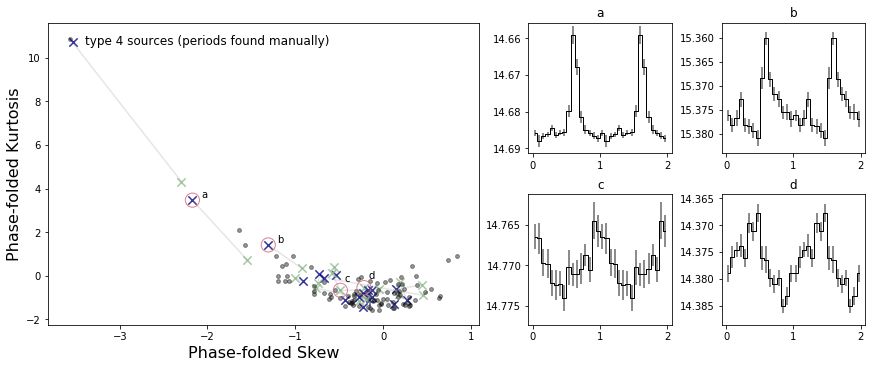

In [70]:
#use subplots
fig3 = plt.figure(figsize=(12,5),constrained_layout=True)
gs = fig3.add_gridspec(4,10)
ax1 = fig3.add_subplot(gs[:, :-4])
# ax1.set_title('gs[0, :]')
ax2 = fig3.add_subplot(gs[:2, -4:-2])
ax2.set_title('a')
ax3 = fig3.add_subplot(gs[:2, -2:])
ax3.set_title('b')
ax4 = fig3.add_subplot(gs[2:, -4:-2])
ax4.set_title('c')
ax5 = fig3.add_subplot(gs[2:, -2:])
ax5.set_title('d')

#skew-kurt plot
for s in range(len(alls)):
    row = alls.iloc[s]
    srcn = int(row['src_n'])
    if srcn not in xlist:
        ax1.scatter(row['pf skew '],row['pf kurtosis'],color='black',alpha=0.4,marker='o',s=15)
    else:
        xrow = xpf[xpf['src_n']==srcn]
        if s==1: ax1.scatter(row['pf skew '],row['pf kurtosis'],color='navy',alpha=0.8,marker='+',s=70,label='pdgram best')
        else:ax1.scatter(row['pf skew '],row['pf kurtosis'],color='navy',alpha=0.8,marker='x',s=70)
        if s==1:ax1.scatter(xrow['est skew'],xrow['est kurt'],color='darkseagreen',alpha=0.8,marker='+',s=70,label='est. from X-ray')
        else:ax1.scatter(xrow['est skew'],xrow['est kurt'],color='darkseagreen',alpha=0.8,marker='x',s=70)
        if s==1:ax1.plot([float(row['pf skew ']),float(xrow['est skew'])],[float(row['pf kurtosis']),float(xrow['est kurt'])],color='grey',alpha=0.2,label='same source')
        ax1.plot([float(row['pf skew ']),float(xrow['est skew'])],[float(row['pf kurtosis']),float(xrow['est kurt'])],color='grey',alpha=0.2)
# plt.ylim(-2,4)
# plt.xlim(-2.5,1)
ax1.set_ylabel('Phase-folded Kurtosis',fontsize=16)
ax1.set_xlabel('Phase-folded Skew',fontsize=16)
# plt.text(-3.5,10,'periods for type 4 found manually')
ax1.text(-3.4,10.6,'type 4 sources (periods found manually)',fontsize=12)

ax5.step(mid2,avg2,where='mid',color='black',linewidth=1)
ax5.errorbar(mid2,avg2,yerr=err2,color='black',alpha=0.6,ls='none')
amax = np.max(avg2)+np.max(err2)
amin = np.min(avg2)-np.max(err2)
ax5.set_ylim(amax+.001,amin-.001)

#11
ax4.step(mid11,avg11,where='mid',color='black',linewidth=1)
ax4.errorbar(mid11,avg11,yerr=err11,color='black',alpha=0.6,ls='none')
amax = np.max(avg11)+np.max(err11)
amin = np.min(avg11)-np.max(err11)
ax4.set_ylim(amax+.001,amin-.001)

ax3.step(mid36,avg36,where='mid',color='black',linewidth=1)
ax3.errorbar(mid36,avg36,yerr=err36,color='black',alpha=0.6,ls='none')
amax = np.max(avg36)+np.max(err36)
amin = np.min(avg36)-np.max(err36)
ax3.set_ylim(amax+.001,amin-.001)

# ax.scatter(0.187903,-0.293793,facecolor='none',color='black',s=200,alpha=0.5)#6
ax2.step(mid23,avg23,where='mid',color='black',linewidth=1)
ax2.errorbar(mid23,avg23,yerr=err23,color='black',alpha=0.6,ls='none')
amax = np.max(avg23)+np.max(err23)
amin = np.min(avg23)-np.max(err23)
ax2.set_ylim(amax+.001,amin-.001)

#put circles and annotate corresponding points
ax1.scatter(-1.307362,1.414957,facecolor='none',color=pink,s=200,alpha=0.8)
ax1.scatter(-0.216993,-0.540924,facecolor='none',color=pink,s=200,alpha=0.8) #2
ax1.scatter(-0.485546,-0.664637,facecolor='none',color=pink,s=200,alpha=0.8) #11
# ax1.scatter(-0.216993,-0.540924,facecolor='none',color=pink,s=200,alpha=0.8) #11 gram

ax1.scatter(-2.171697,3.468811,facecolor='none',color=pink,s=200,alpha=0.8,label='inset phase-fold')#23
ax1.text(-2.171697+.1,3.468811+.1,'a')
ax1.text(-1.307362+.1,1.414957+.1,'b')
ax1.text(-0.485546+.05,-0.664637+.4,'c')
ax1.text(-0.216993+.05,-0.540924+.4,'d')
# sf('grid_skewkurt')

### version where two profiles (each from a different X-ray category)
- 7: est. doesn't look good
- try 11 still but otherwise 13
- 6, 27, 2, 3, 49, 56, 60
- 9, 23, 36, 54

- so start with 11, 7, 36, 3

In [117]:
row = xpf[xpf['src_n']==11]
float(row['est'])

28.51

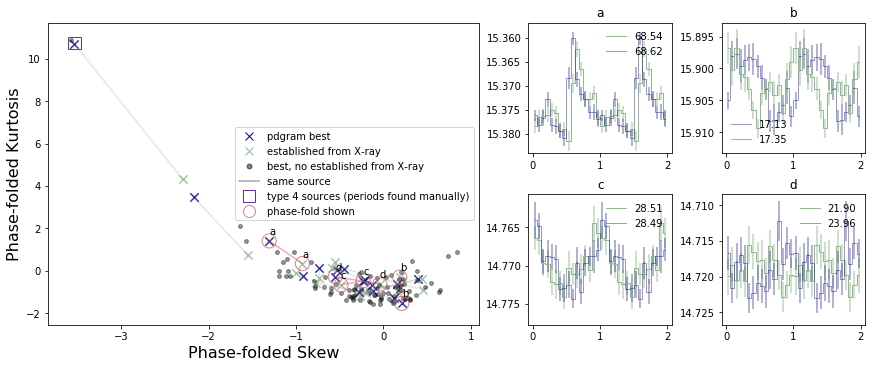

In [160]:
#use subplots
fig3 = plt.figure(figsize=(12,5),constrained_layout=True)
gs = fig3.add_gridspec(4,10)
ax1 = fig3.add_subplot(gs[:, :-4])
# ax1.set_title('gs[0, :]')
ax2 = fig3.add_subplot(gs[:2, -4:-2])
ax2.set_title('a') #: src 36
ax3 = fig3.add_subplot(gs[:2, -2:])
ax3.set_title('b') #: src 6
ax4 = fig3.add_subplot(gs[2:, -4:-2])
ax4.set_title('c') #: src 11
ax5 = fig3.add_subplot(gs[2:, -2:])
ax5.set_title('d') #: src 7

#skew-kurt plot
for s in range(len(alls)):
    row = alls.iloc[s]
    srcn = int(row['src_n'])
    if srcn not in xlist:
        ax1.scatter(row['pf skew '],row['pf kurtosis'],color='black',alpha=0.4,marker='o',s=15)
    else:
        if srcn in [6,7,36,11]:color=pink; alpha=0.5
        else: color='grey';alpha=0.2
        xrow = xpf[xpf['src_n']==srcn]
        if s==1: ax1.scatter(xrow['gram skew'],xrow['gram kurt'],color='navy',alpha=0.8,marker='+',s=70,label='pdgram best')
        else:ax1.scatter(xrow['gram skew'],xrow['gram kurt'],color='navy',alpha=0.8,marker='x',s=70)
        if s==1:ax1.scatter(xrow['est skew'],xrow['est kurt'],color='darkseagreen',alpha=0.8,marker='+',s=70,label='est. from X-ray')
        else:ax1.scatter(xrow['est skew'],xrow['est kurt'],color='darkseagreen',alpha=0.8,marker='x',s=70)
        if s==1:ax1.plot([float(xrow['gram skew']),float(xrow['est skew'])],[float(xrow['gram kurt']),float(xrow['est kurt'])],color=color,alpha=alpha,label='same source')
        else: ax1.plot([float(xrow['gram skew']),float(xrow['est skew'])],[float(xrow['gram kurt']),float(xrow['est kurt'])],color=color,alpha=alpha)
# plt.ylim(-2,4)
# plt.xlim(-2.5,1)
ax1.set_ylabel('Phase-folded Kurtosis',fontsize=16)
ax1.set_xlabel('Phase-folded Skew',fontsize=16)
# plt.text(-3.5,10,'periods for type 4 found manually')
# ax1.text(-3.4,10.6,'type 4 sources (periods found manually)',fontsize=12)
#put rectangle around those sources
ax1.add_patch(rec((-3.617,10.45),.15,.6,facecolor='none',edgecolor='rebeccapurple'))

row = xpf[xpf['src_n']==6]
per = float(row['est'])
est = f'{per:.2f}'
per = float(row['gram'])
gram = f'{per:.2f}'
ax3.step(mid6p,avg6p,where='mid',color='navy',linewidth=1,alpha=.4,label=est)
ax3.errorbar(mid6p,avg6p,yerr=err6p,color='navy',alpha=0.4,ls='none')
amax = np.max(avg6p)+np.max(err6p)
amin = np.min(avg6p)-np.max(err6p)
ax3.set_ylim(amax+.001,amin-.001)

ax3.step(mid6,avg6,where='mid',color='darkseagreen',linewidth=1,label=gram)
ax3.errorbar(mid6,avg6,yerr=err6,color='darkseagreen',alpha=0.6,ls='none')
amax = np.max(avg6)+np.max(err6)
amin = np.min(avg6)-np.max(err6)
ax3.set_ylim(amax+.001,amin-.001)


#11
row = xpf[xpf['src_n']==11]
per = float(row['est'])
est = f'{per:.2f}'
per = float(row['gram'])
gram = f'{per:.2f}'
ax4.step(mid11,avg11,where='mid',color='darkseagreen',linewidth=1,label=est)
ax4.errorbar(mid11,avg11,yerr=err11,color='darkseagreen',alpha=0.6,ls='none')
amax = np.max(avg11)+np.max(err11)
amin = np.min(avg11)-np.max(err11)
ax4.set_ylim(amax+.001,amin-.001)
#11 gram
ax4.step(mid11p,avg11p,where='mid',color='navy',linewidth=1,alpha=0.4,label=gram)
ax4.errorbar(mid11p,avg11p,yerr=err11p,color='navy',alpha=0.4,ls='none')
amax = np.max(avg11p)+np.max(err11p)
amin = np.min(avg11p)-np.max(err11p)
ax4.set_ylim(amax+.001,amin-.001)

row = xpf[xpf['src_n']==36]
per = float(row['est'])
est = f'{per:.2f}'
per = float(row['gram'])
gram = f'{per:.2f}'
ax2.step(mid36,avg36,where='mid',color='darkseagreen',linewidth=1,label=est)
ax2.errorbar(mid36,avg36,yerr=err36,color='darkseagreen',alpha=0.6,ls='none')
amax = np.max(avg36)+np.max(err36)
amin = np.min(avg36)-np.max(err36)
ax2.set_ylim(amax+.001,amin-.001)

ax2.step(mid36p,avg36p,where='mid',color='navy',linewidth=1,alpha=0.4,label=gram)
ax2.errorbar(mid36p,avg36p,yerr=err36p,color='navy',alpha=0.4,ls='none')
amax = np.max(avg36p)+np.max(err36p)
amin = np.min(avg36p)-np.max(err36p)
ax2.set_ylim(amax+.001,amin-.001)

row = xpf[xpf['src_n']==7]
per = float(row['est'])
est = f'{per:.2f}'
per = float(row['gram'])
gram = f'{per:.2f}'
ax5.step(mid7,avg7,where='mid',color='darkseagreen',linewidth=1,label=est)
ax5.errorbar(mid7,avg7,yerr=err7,color='darkseagreen',alpha=0.6,ls='none')
amax = np.max(avg7)+np.max(err7)
amin = np.min(avg7)-np.max(err7)
ax5.set_ylim(amax+.001,amin-.001)

ax5.step(mid7p,avg7p,where='mid',color='navy',linewidth=1,alpha=0.4,label=gram)
ax5.errorbar(mid7p,avg7p,yerr=err7p,color='navy',alpha=0.4,ls='none')
amax = np.max(avg7p)+np.max(err7p)
amin = np.min(avg7p)-np.max(err7p)
ax5.set_ylim(amax+.001,amin-.001)
ax2.legend(frameon=False);ax3.legend(frameon=False);ax4.legend(frameon=False);ax5.legend(frameon=False)
#put circles and annotate corresponding points -- switch to using table
labdict = {36:'a',6:'b',11:'c',7:'d'}
def circle(src):
    row = xpf[xpf['src_n']==src]
    ax1.scatter(row['est skew'],row['est kurt'],facecolor='none',color=pink,s=200,alpha=0.8)
    ax1.scatter(row['gram skew'],row['gram kurt'],facecolor='none',color=pink,s=200,alpha=0.8)
    label = labdict[src]
    ax1.text(row['est skew'],row['est kurt']+.3,label)
    ax1.text(row['gram skew'],row['gram kurt']+.3,label)
circle(7)
circle(36)
circle(11)
circle(6)
# ax1.text(-2.171697+.1,3.468811+.1,'a')
# ax1.text(-1.307362+.1,1.414957+.1,'b')
# ax1.text(-0.485546+.05,-0.664637+.4,'c')
# ax1.text(0.209776,-1.53134,'d')
#make legend
legend_elements = [Line2D([0], [0], color='navy',marker='x',markersize=8, label='pdgram best',ls='none'),
                   Line2D([0], [0], color='darkseagreen',marker='x',markersize=8, label='established from X-ray',ls='none'),
                  Line2D([0], [0], color='black',marker='o', label='best, no established from X-ray',ls='none',alpha=0.5,markersize=5),
                  Line2D([0], [0], color='grey', label='same source',alpha=0.7),
                Line2D([0], [0],marker='s',markersize=12,label='type 4 sources (periods found manually)',markerfacecolor='none',markeredgecolor='rebeccapurple',ls='none'),
                  Line2D([0], [0], marker='o',markerfacecolor='none',color=pink,markersize=12,alpha=0.8, label='phase-fold shown',ls='none')]
ax1.legend(handles=legend_elements,loc='center right')
# sf('grid_skewkurt_v2')

In [80]:
xpf[xpf['src_n']==6] 

src_n    est   best  est skew  est kurt  best skew  best kurt       gram  \
5      6  17.13  17.13  0.187903 -0.293793   0.187903  -0.293793  17.347929   

   gram kurt  gram skew  
5   -1.53134   0.209776

## (just looking at change from est)


Text(0, 0.5, 'Best Kurt - Est. Kurt')

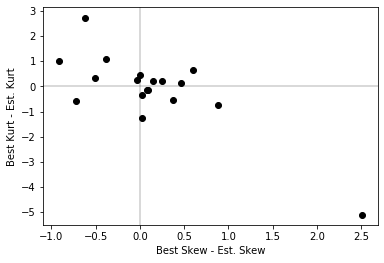

In [118]:
plt.scatter(xpf['best skew']-xpf['est skew'],xpf['best kurt']-xpf['est kurt'],color='black')
plt.axvline(0,color='black',alpha=0.2)
plt.axhline(0,color='black',alpha=0.2)
plt.xlabel('Best Skew - Est. Skew')
plt.ylabel('Best Kurt - Est. Kurt')
#positive in y: best has higher kurtosis (more FRED)
#negative in x: best has lower skew (more FRED)
#so four sources more FRED using best; six sources more FRED with est.

# Possible Appendix/Helpful Gallery of LCs/Color-Mags by Type

In [74]:
len(type1)

6

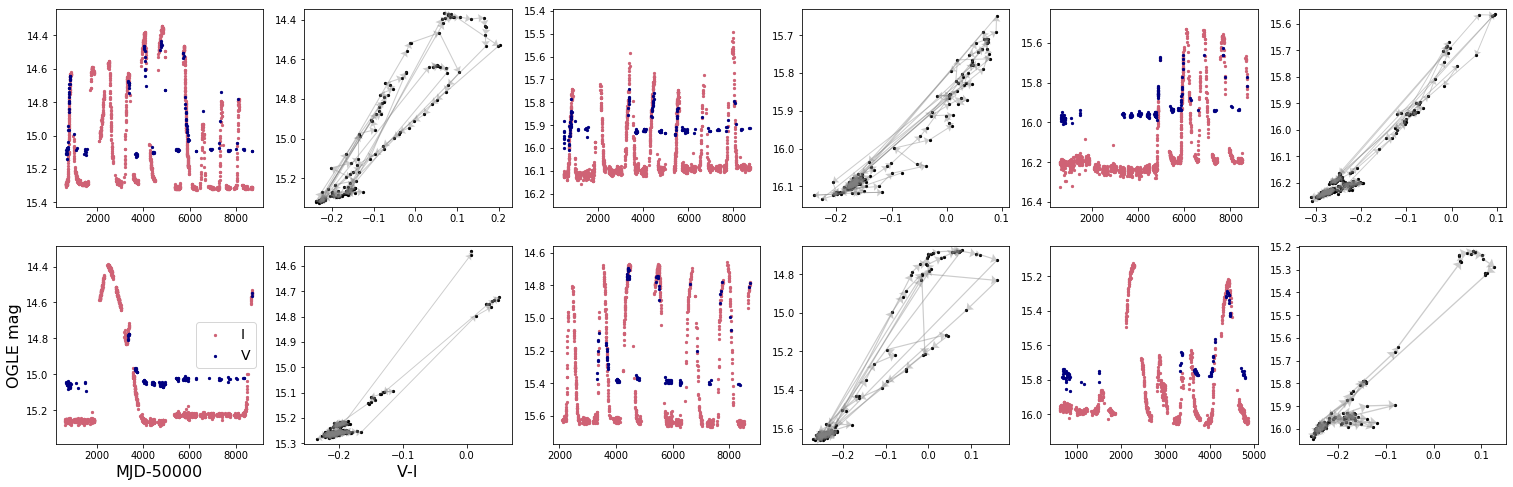

In [91]:
fig = plt.figure(figsize=(26,8))
i = 1
for t in type1:
    try:iband,vband = o.getIV(t,cross,both=True,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=False)
    except:iband,vband = o.getIV(t,cross2,both=True,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=False)
    #color-mag
    interp = o.colormag(iband,vband,plot=False,printcorr=False,retint=True,ctime=True,cmap='viridis',both=True,save=False,file='')
    ax = fig.add_subplot(2,6,i)
    #first do I and V mag
    ax.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=5,label='I')
    ax.scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=5,label='V')    
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    ax.set_ylim(maxi+.1,mini-.1)
    #set labels
    if i==7:
        ax.legend(fontsize=14)
        ax.set_xlabel('MJD-50000',fontsize=16)
        ax.set_ylabel('OGLE mag',fontsize=16)

    #now color mag
    i+=1
    ax = fig.add_subplot(2,6,i)
    vi = vband['V mag']-interp
    ax.scatter(vi,interp,color='black',s=5)
    yvect = interp[1:]-interp[:-1]
    xvect = vi[1:]-vi[:-1]
    ax.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.4,headwidth=8)
    maxi,mini = np.max(interp),np.min(interp)
    ax.set_ylim(maxi+.02,mini-.02)
    if i==8:ax.set_xlabel('V-I',fontsize=16)
#     if i == 4:
#         ax.set_ylabel('$\mathrm{I_{int}}$',fontsize=14)
#         ax.set_xlabel('$\mathrm{V-I_{int}}$',fontsize=14)

    i+=1
# fig.suptitle('Type 3 Source Color-Mag')
# sf('type1gallery')

In [86]:
len(type2+type3)

23

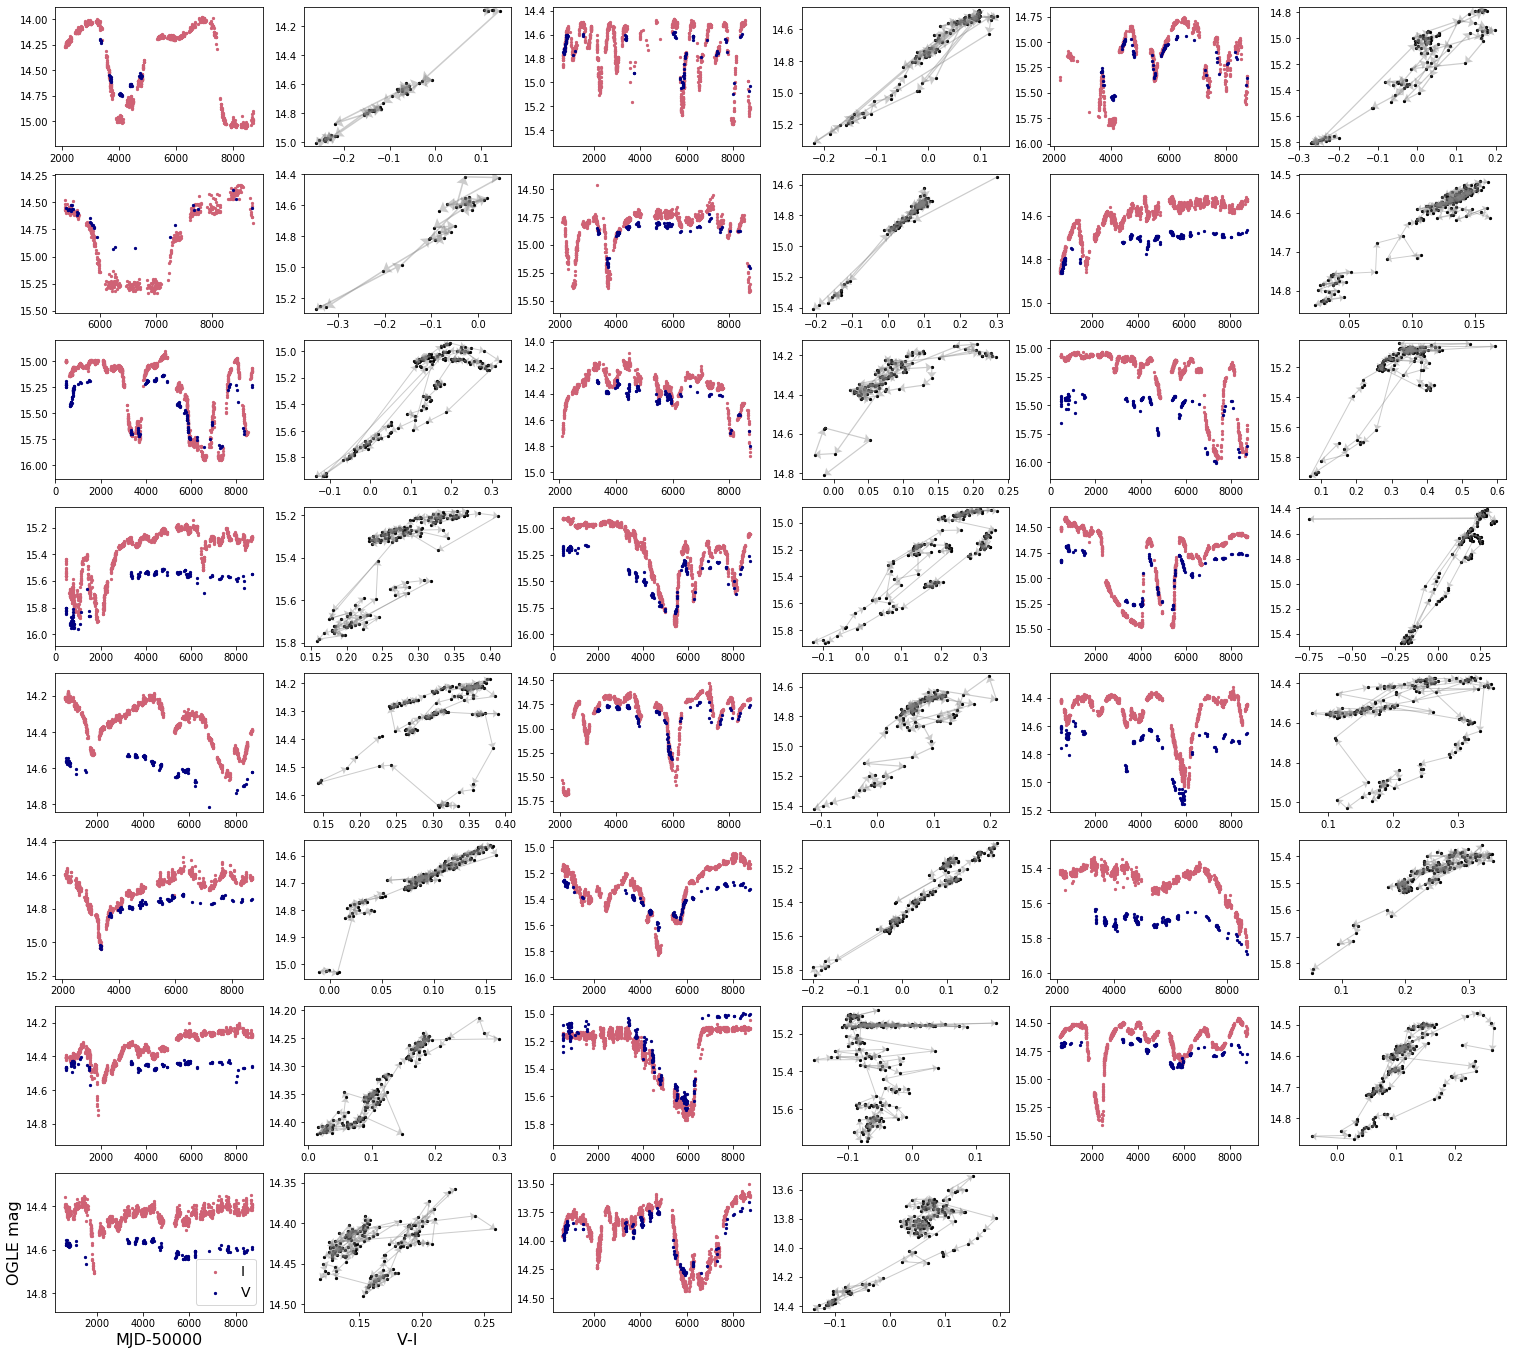

In [93]:
fig = plt.figure(figsize=(26,24))
i = 1
for t in type2+type3:
    try:iband,vband = o.getIV(t,cross,both=True,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=False)
    except:iband,vband = o.getIV(t,cross2,both=True,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=False)
    #color-mag
    interp = o.colormag(iband,vband,plot=False,printcorr=False,retint=True,ctime=True,cmap='viridis',both=True,save=False,file='')
    ax = fig.add_subplot(8,6,i)
    #first do I and V mag
    ax.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=5,label='I')
    ax.scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=5,label='V')    
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    ax.set_ylim(maxi+.18,mini-.1)
    #set labels
    if i==43:
        ax.legend(fontsize=14)
        ax.set_xlabel('MJD-50000',fontsize=16)
        ax.set_ylabel('OGLE mag',fontsize=16)

    #now color mag
    i+=1
    ax = fig.add_subplot(8,6,i)
    vi = vband['V mag']-interp
    ax.scatter(vi,interp,color='black',s=5)
    yvect = interp[1:]-interp[:-1]
    xvect = vi[1:]-vi[:-1]
    ax.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.4,headwidth=8)
    maxi,mini = np.max(interp),np.min(interp)
    ax.set_ylim(maxi+.02,mini-.02)
    if i==44:ax.set_xlabel('V-I',fontsize=16)
#     if i == 4:
#         ax.set_ylabel('$\mathrm{I_{int}}$',fontsize=14)
#         ax.set_xlabel('$\mathrm{V-I_{int}}$',fontsize=14)

    i+=1
# sf('type2gallery')

In [94]:
len(type5)

29

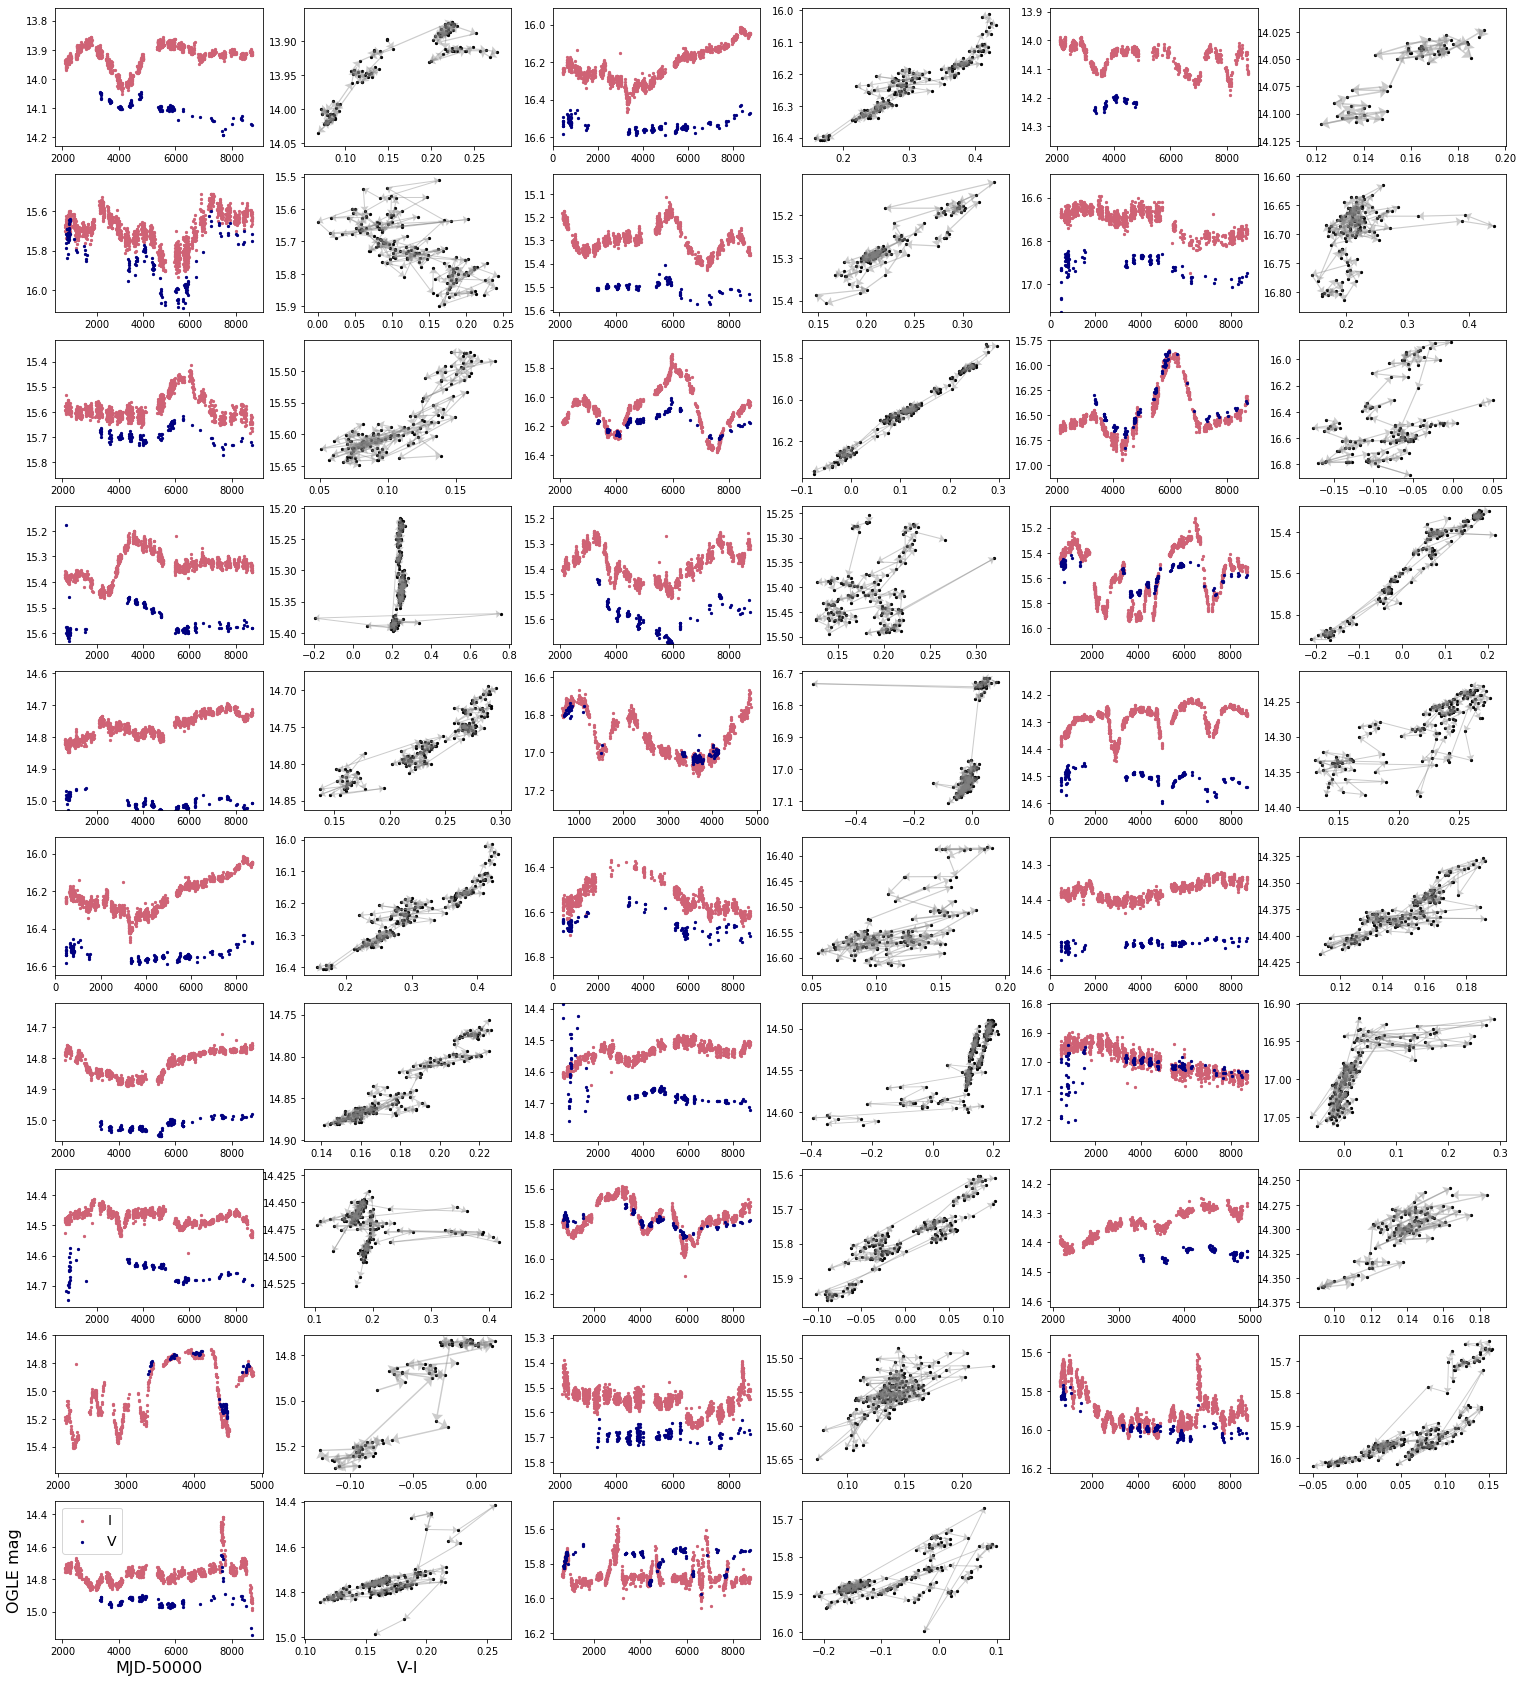

In [95]:
fig = plt.figure(figsize=(26,30))
i = 1
for t in type5:
    try:iband,vband = o.getIV(t,cross,both=True,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=False)
    except:iband,vband = o.getIV(t,cross2,both=True,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=False)
    #color-mag
    interp = o.colormag(iband,vband,plot=False,printcorr=False,retint=True,ctime=True,cmap='viridis',both=True,save=False,file='')
    ax = fig.add_subplot(10,6,i)
    #first do I and V mag
    ax.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=5,label='I')
    ax.scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=5,label='V')    
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    ax.set_ylim(maxi+.18,mini-.1)
    #set labels
    if i==43+12:
        ax.legend(fontsize=14)
        ax.set_xlabel('MJD-50000',fontsize=16)
        ax.set_ylabel('OGLE mag',fontsize=16)

    #now color mag
    i+=1
    ax = fig.add_subplot(10,6,i)
    vi = vband['V mag']-interp
    ax.scatter(vi,interp,color='black',s=5)
    yvect = interp[1:]-interp[:-1]
    xvect = vi[1:]-vi[:-1]
    ax.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.4,headwidth=8)
    maxi,mini = np.max(interp),np.min(interp)
    ax.set_ylim(maxi+.02,mini-.02)
    if i==44+12:ax.set_xlabel('V-I',fontsize=16)
#     if i == 4:
#         ax.set_ylabel('$\mathrm{I_{int}}$',fontsize=14)
#         ax.set_xlabel('$\mathrm{V-I_{int}}$',fontsize=14)

    i+=1

In [97]:
#try out ordering them by their placement in base num and stdev ratio to make it make more sense


[['c', 0], ['a', 1], ['b', 2]]

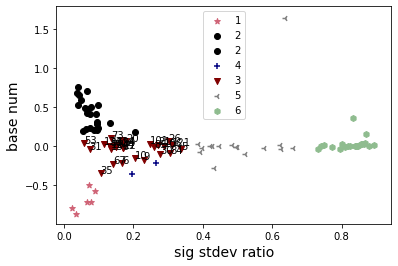

In [101]:
fulltplot(x='sig stdev ratio',y='base num',legend=True,tbool=[False,False,False,False,True,False,False]
          ,between=False,tab=alls)


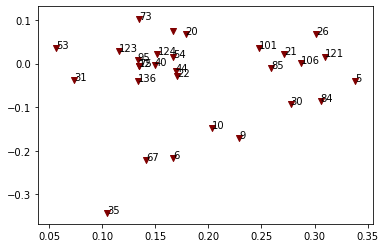

In [111]:
o.tplot(type5,alls,text=True,marker='v',color='maroon',x='sig stdev ratio',y='base num')
# plt.ylim(-.1,.05)

In [135]:
#in order based on the above; in which horizontal will be sig stdev and vertical is base num
t3ord = [53,73,20,4,101,21,26,106,121,
        31,123,95,75,124,40,54,44,136,22,85,
        12,35,67,6,10,9,30,84,5]

for now not adding color-mag errorbars

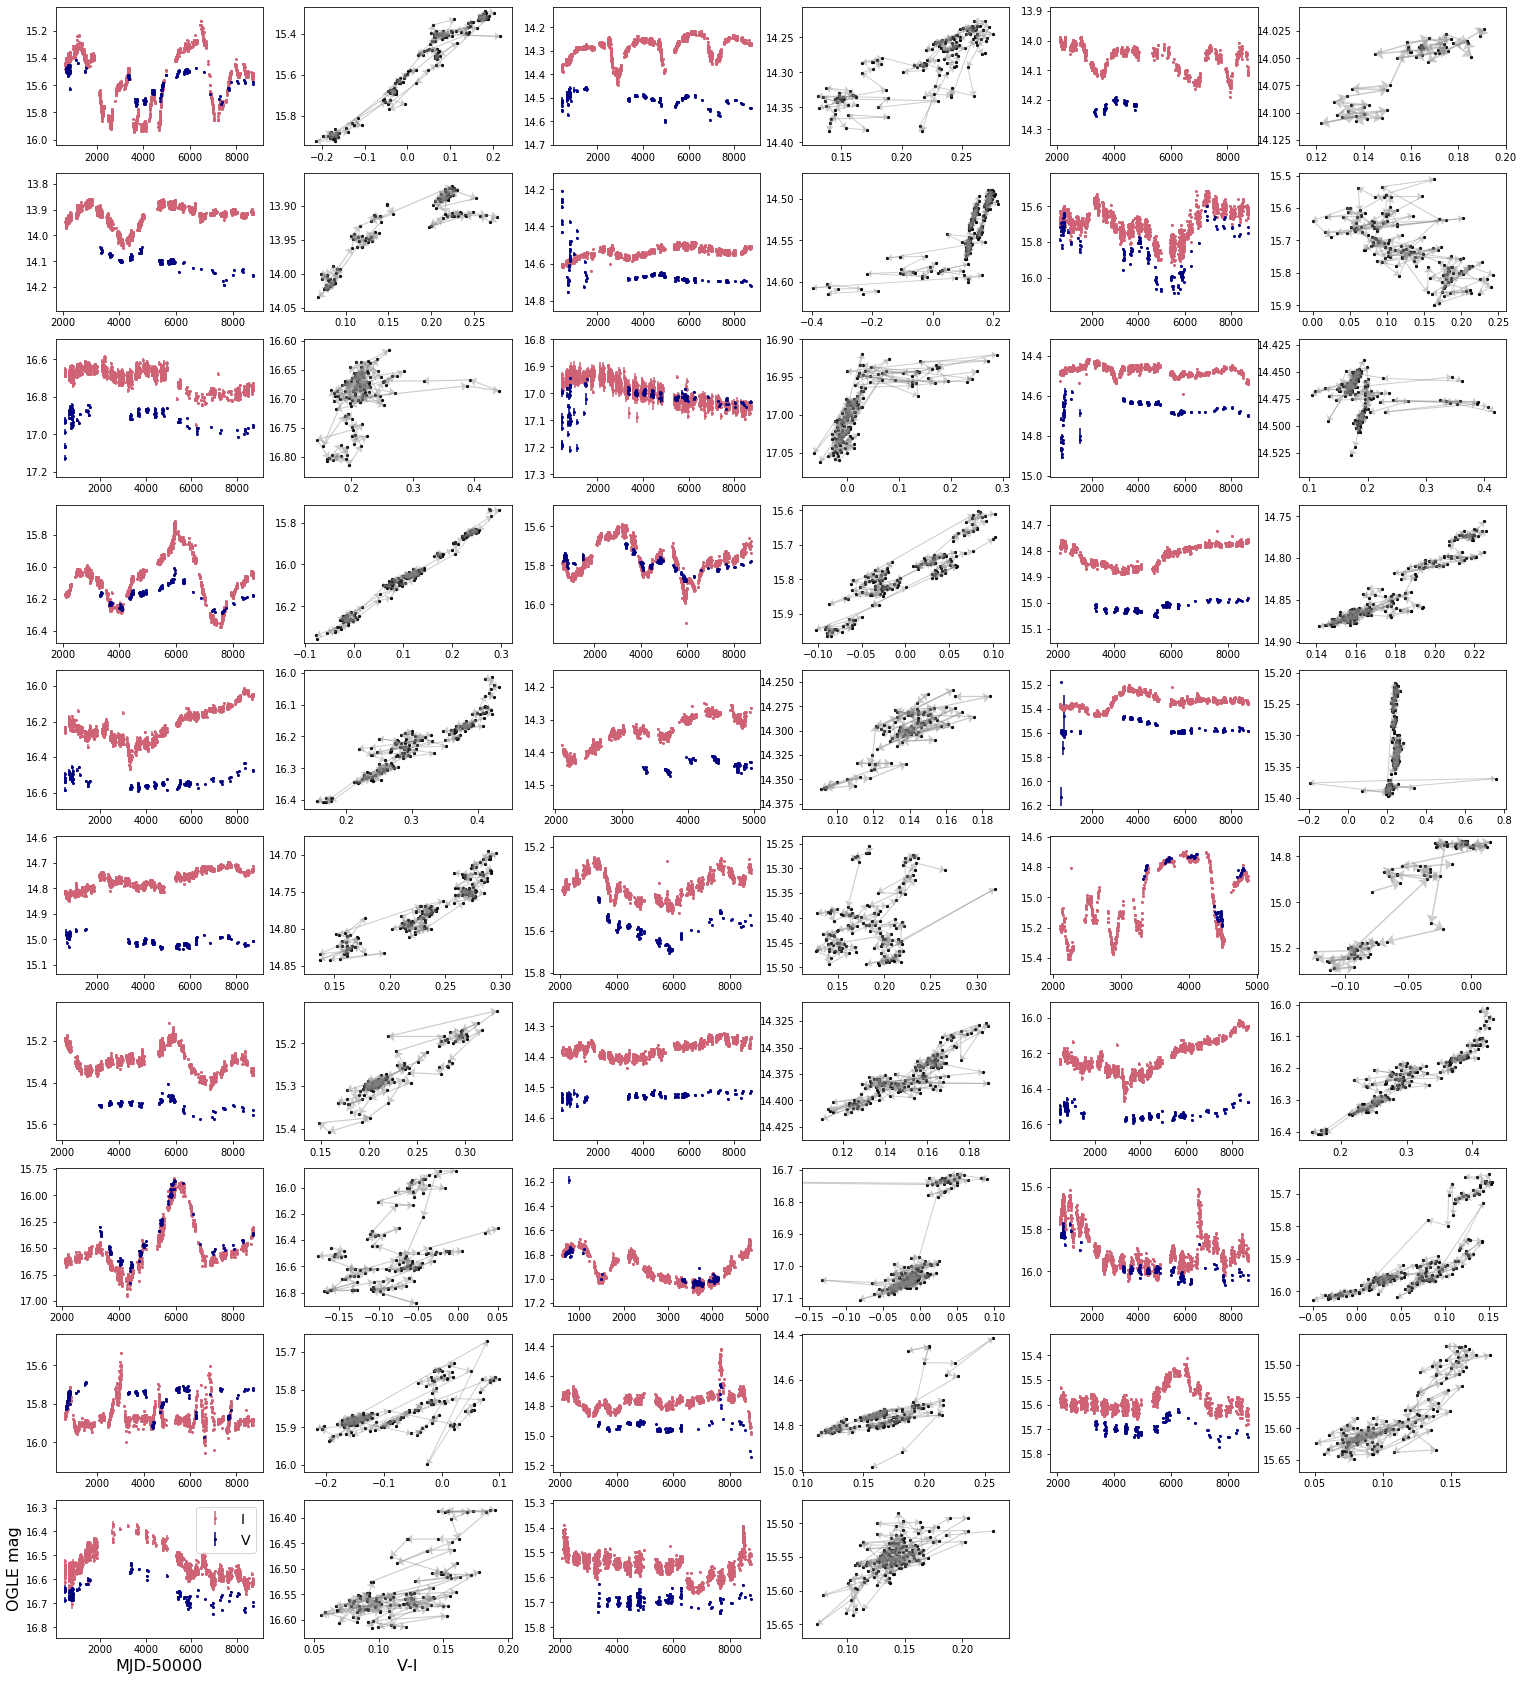

In [251]:
fig = plt.figure(figsize=(26,30))
i = 1
for t in t3ord:
    try:iband,vband = o.getIV(t,cross,both=True,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=False)
    except:iband,vband = o.getIV(t,cross2,both=True,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=False)
    #color-mag
    interp = o.colormag(iband,vband,plot=False,printcorr=False,retint=True,ctime=True,cmap='viridis',both=True,save=False,file='')
    ax = fig.add_subplot(10,6,i)
    #first do I and V mag
    ax.errorbar(iband['MJD-50000'],iband['I mag'],yerr=iband['I mag err'],color=pink,markersize=2,label='I',ls='none',marker='o')
    ax.errorbar(vband['MJD-50000'],vband['V mag'],yerr=vband['V mag err'],color='navy',markersize=2,label='V',ls='none',marker='o')    
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    if np.max(vband['V mag'])>maxi: maxi = np.max(vband['V mag'])
    if np.min(vband['V mag'])<mini: mini = np.min(vband['V mag'])
    ax.set_ylim(maxi+.1,mini-.1)
    #set labels
    if i==43+12:
        ax.legend(fontsize=14)
        ax.set_xlabel('MJD-50000',fontsize=16)
        ax.set_ylabel('OGLE mag',fontsize=16)

    #now color mag
    i+=1
    ax = fig.add_subplot(10,6,i)
    vi = vband['V mag']-interp
    ax.scatter(vi,interp,color='black',s=5)
    yvect = interp[1:]-interp[:-1]
    xvect = vi[1:]-vi[:-1]
    ax.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.4,headwidth=8)
    maxi,mini = np.max(interp),np.min(interp)
    ax.set_ylim(maxi+.02,mini-.02)
    if np.min(vi)<-.4:ax.set_xlim(-.16,.12) #getting rid of one outlier
    if i==44+12:ax.set_xlabel('V-I',fontsize=16)
#     if i == 4:
#         ax.set_ylabel('$\mathrm{I_{int}}$',fontsize=14)
#         ax.set_xlabel('$\mathrm{V-I_{int}}$',fontsize=14)

    i+=1
# sf('type3gallery')

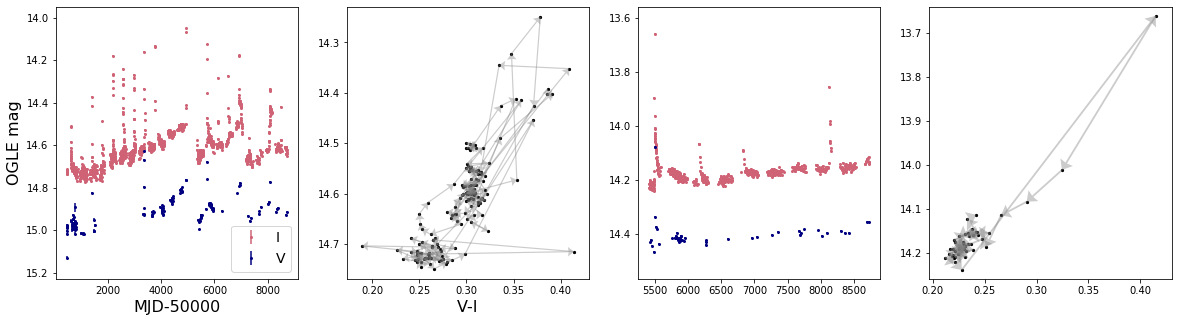

In [256]:
fig = plt.figure(figsize=(20,5))
i = 1
for t in type4:
    try:iband,vband = o.getIV(t,cross,both=True,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=False)
    except:iband,vband = o.getIV(t,cross2,both=True,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=False)
    #color-mag
    interp = o.colormag(iband,vband,plot=False,printcorr=False,retint=True,ctime=True,cmap='viridis',both=True,save=False,file='')
    ax = fig.add_subplot(1,4,i)
    #first do I and V mag
    ax.errorbar(iband['MJD-50000'],iband['I mag'],yerr=iband['I mag err'],color=pink,markersize=2,label='I',ls='none',marker='o')
    ax.errorbar(vband['MJD-50000'],vband['V mag'],yerr=vband['V mag err'],color='navy',markersize=2,label='V',ls='none',marker='o')    
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    if np.max(vband['V mag'])>maxi: maxi = np.max(vband['V mag'])
    if np.min(vband['V mag'])<mini: mini = np.min(vband['V mag'])
    ax.set_ylim(maxi+.1,mini-.1)
    #set labels
    if i==1:
        ax.legend(fontsize=14)
        ax.set_xlabel('MJD-50000',fontsize=16)
        ax.set_ylabel('OGLE mag',fontsize=16)

    #now color mag
    i+=1
    ax = fig.add_subplot(1,4,i)
    vi = vband['V mag']-interp
    ax.scatter(vi,interp,color='black',s=5)
    yvect = interp[1:]-interp[:-1]
    xvect = vi[1:]-vi[:-1]
    ax.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.4,headwidth=8)
    maxi,mini = np.max(interp),np.min(interp)
    ax.set_ylim(maxi+.02,mini-.02)
    if np.min(vi)<-.4:ax.set_xlim(-.16,.12) #getting rid of one outlier
    if i==2:ax.set_xlabel('V-I',fontsize=16)
    i+=1
# sf('type4gallery')

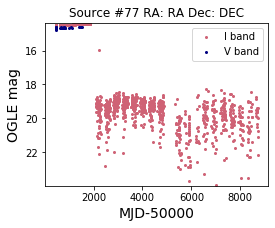

In [262]:
plot(type6[9])

empty file for OIII I


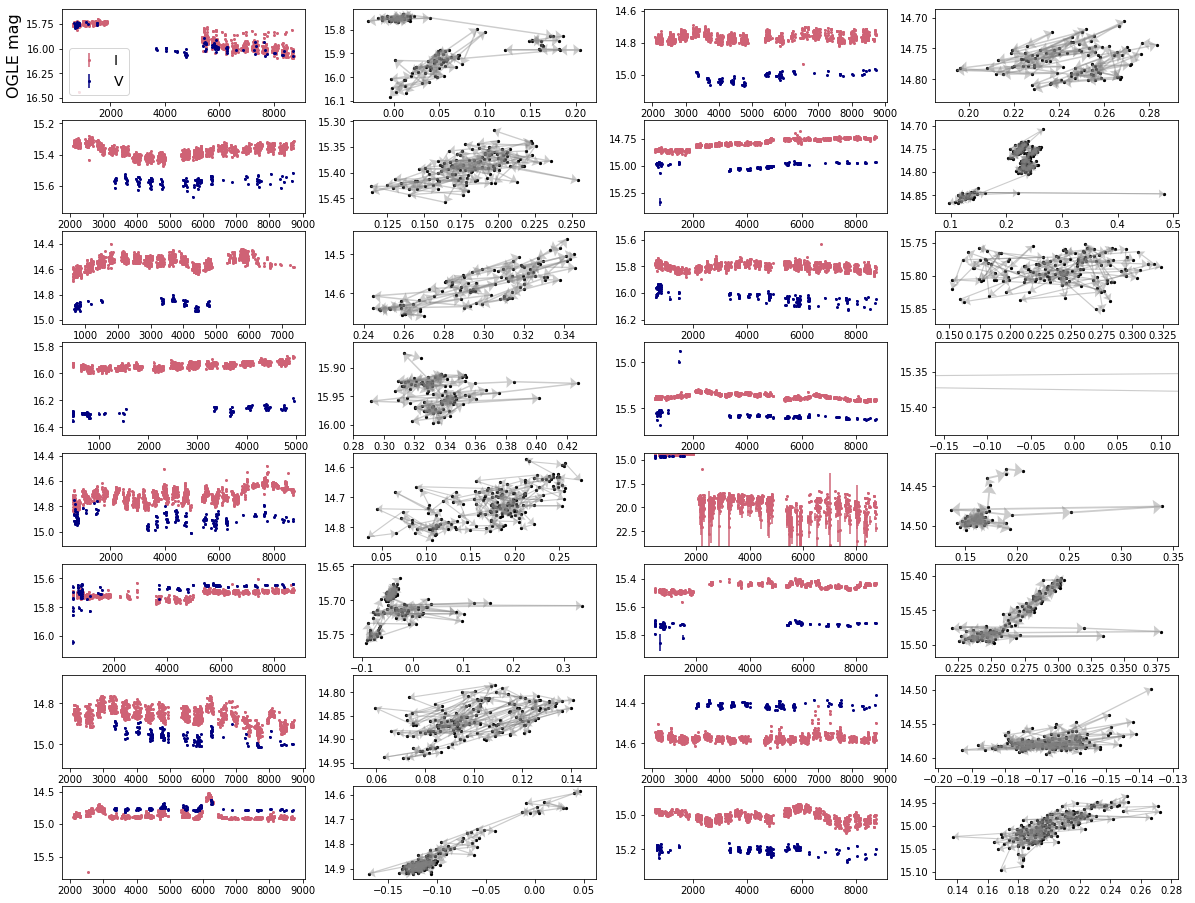

In [259]:
fig = plt.figure(figsize=(20,18))
i = 1
for t in type6:
    try:iband,vband = o.getIV(t,cross,both=True,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=False)
    except:iband,vband = o.getIV(t,cross2,both=True,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=False)
    #color-mag
    interp = o.colormag(iband,vband,plot=False,printcorr=False,retint=True,ctime=True,cmap='viridis',both=True,save=False,file='')
    ax = fig.add_subplot(8,4,i)
    #first do I and V mag
    ax.errorbar(iband['MJD-50000'],iband['I mag'],yerr=iband['I mag err'],color=pink,markersize=2,label='I',ls='none',marker='o')
    ax.errorbar(vband['MJD-50000'],vband['V mag'],yerr=vband['V mag err'],color='navy',markersize=2,label='V',ls='none',marker='o')    
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    if np.max(vband['V mag'])>maxi: maxi = np.max(vband['V mag'])
    if np.min(vband['V mag'])<mini: mini = np.min(vband['V mag'])
    ax.set_ylim(maxi+.1,mini-.1)
    #set labels
    if i==1:
        ax.legend(fontsize=14)
        ax.set_xlabel('MJD-50000',fontsize=16)
        ax.set_ylabel('OGLE mag',fontsize=16)

    #now color mag
    i+=1
    ax = fig.add_subplot(8,4,i)
    vi = vband['V mag']-interp
    ax.scatter(vi,interp,color='black',s=5)
    yvect = interp[1:]-interp[:-1]
    xvect = vi[1:]-vi[:-1]
    ax.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.4,headwidth=8)
    maxi,mini = np.max(interp),np.min(interp)
    ax.set_ylim(maxi+.02,mini-.02)
    if np.min(vi)<-.4:ax.set_xlim(-.16,.12) #getting rid of one outlier
    if i==2:ax.set_xlabel('V-I',fontsize=16)
    i+=1
#sf(type5gallery)

In [270]:
len(typet)

7

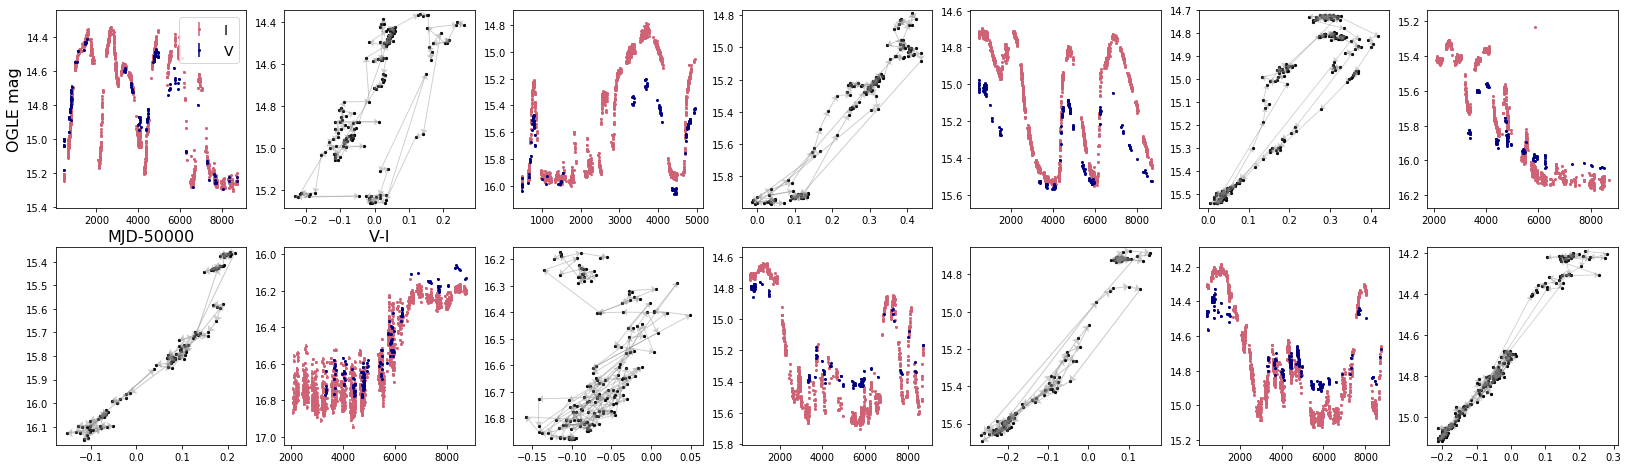

In [277]:
fig = plt.figure(figsize=(28,8))
i = 1
for t in typet:
    try:iband,vband = o.getIV(t,cross,both=True,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=False)
    except:iband,vband = o.getIV(t,cross2,both=True,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=False)
    #color-mag
    interp = o.colormag(iband,vband,plot=False,printcorr=False,retint=True,ctime=True,cmap='viridis',both=True,save=False,file='')
    ax = fig.add_subplot(2,7,i)
    #first do I and V mag
    ax.errorbar(iband['MJD-50000'],iband['I mag'],yerr=iband['I mag err'],color=pink,markersize=2,label='I',ls='none',marker='o')
    ax.errorbar(vband['MJD-50000'],vband['V mag'],yerr=vband['V mag err'],color='navy',markersize=2,label='V',ls='none',marker='o')    
    maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
    if np.max(vband['V mag'])>maxi: maxi = np.max(vband['V mag'])
    if np.min(vband['V mag'])<mini: mini = np.min(vband['V mag'])
    ax.set_ylim(maxi+.1,mini-.1)
    #set labels
    if i==1:
        ax.legend(fontsize=14)
        ax.set_xlabel('MJD-50000',fontsize=16)
        ax.set_ylabel('OGLE mag',fontsize=16)

    #now color mag
    i+=1
    ax = fig.add_subplot(2,7,i)
    vi = vband['V mag']-interp
    ax.scatter(vi,interp,color='black',s=5)
    yvect = interp[1:]-interp[:-1]
    xvect = vi[1:]-vi[:-1]
    ax.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.4,headwidth=8)
    maxi,mini = np.max(interp),np.min(interp)
    ax.set_ylim(maxi+.02,mini-.02)
    if np.min(vi)<-.4:ax.set_xlim(-.16,.12) #getting rid of one outlier
    if i==2:ax.set_xlabel('V-I',fontsize=16)
    i+=1

In [276]:
53 in typet

False

#### remember: skeptical about V band for source that looks similar to type 1

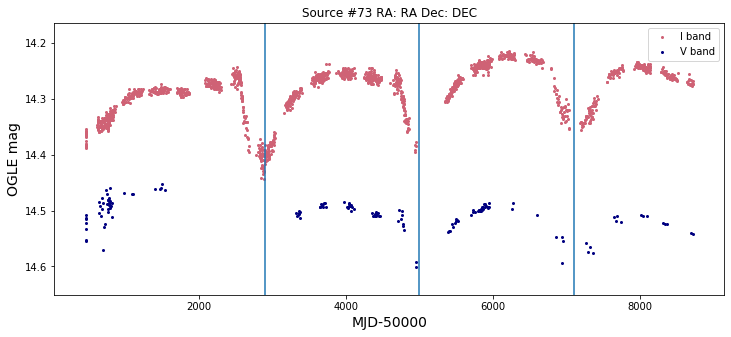

In [127]:
plot(73,fs=(12,5))
plt.axvline(2900)
plt.axvline(2900+2100)
plt.axvline(2900+4200)

In [64]:
typet = []
for i in range(len(alls)):
    row = alls.iloc[i]
    src = row['src_n']
    if '+' in str(row['type']):
        typet.append(int(src))

(-1, 1)

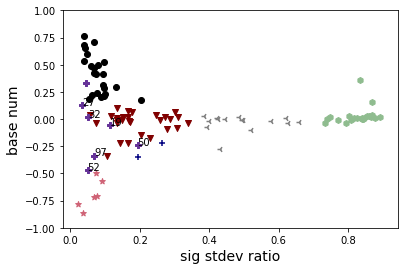

In [284]:
#check if skew gives different division for some of these
fulltplot(x='sig stdev ratio',y='base num',legend=False,tbool=[False,False,False,False,False,False,False,True]
          ,between=True,tab=alls)
# plt.xlim(0,.2)
plt.ylim(-1,1)

(-1, 1)

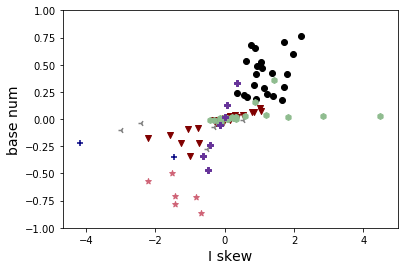

In [301]:
acopy['skew-bn'] = acopy['I skew']/np.nanmedian(acopy['I skew']) - acopy['base num']/np.nanmedian(acopy['base num'])
fulltplot(x='I skew',y='base num',legend=False,tbool=[False,False,False,False,False,False,False,False]
          ,between=True,tab=acopy)
plt.ylim(-1,1)

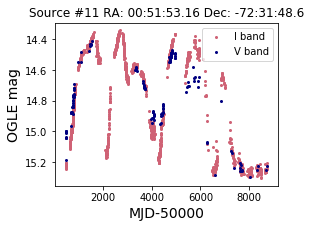

In [290]:
plot(11)

haven't really talked about type 3s generally being less variable than 1 and 2
- and 53,31,35 at higher variability than other type 3; interesting combos
- also see diagonal corr for both type 1 and 2...
- and interesting gap wherein sources look like they're streaming in from type 1 and 2 through 3 into 5

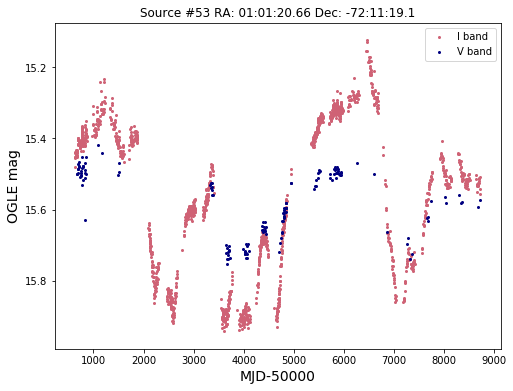

In [158]:
plot(53,fs=(8,6)) #notice color

might actually be important combo

how did 97 but not 53 end up as transition?

Text(0.5, 0, 'V-I')

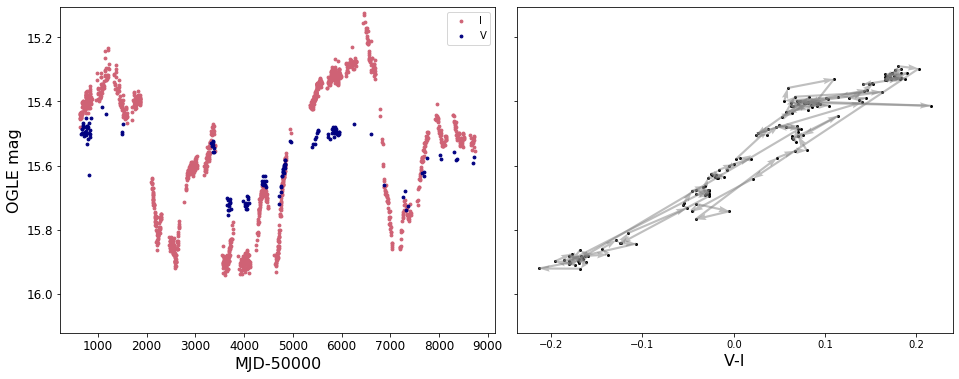

In [183]:
fig,(ax,ax1) = plt.subplots(1,2,figsize=(16,6),sharey=True)
fig.subplots_adjust(wspace=0.05)
iband,vband = o.getIV(53,cross,mlist=mlist1,stack=True)
interp = o.colormag(iband,vband,retint=True,plot=False,printcorr=False)
ax.scatter(iband['MJD-50000'],iband['I mag'],color=pink,s=8,label='I')
maxi,mini = np.max(iband['I mag']),np.min(iband['I mag'])
ax.set_ylim(maxi+.18,mini-.02)

ax.scatter(vband['MJD-50000'],vband['V mag'],color='navy',s=8,label='V')
# maxi,mini = np.max(vband['V mag']),np.min(vband['V mag'])
# ax1.set_ylim(maxi+.02,mini-.02)
# ax.set_xlim(3000,8000)
ax.set_xlabel('MJD-50000',fontsize=16)
ax.set_ylabel('OGLE mag',fontsize=16)
ax.legend()
ax.tick_params(labelsize=12)
#plot color mag from this part
ib = iband[iband['MJD-50000']>4000];ib = ib[ib['MJD-50000']<6100]
vb = vband[vband['MJD-50000']>4000];vb = vb[vb['MJD-50000']<6100]
#new int
inte = o.colormag(ib,vb,retint=True,printcorr=False,plot=False)
vi = vband['V mag']-interp
# im = ax1.scatter(vb['V mag']-inte,inte,color='black')#c=vb['MJD-50000'],cmap='Purples') #to just have color mag from the part of LC shown
im = ax1.scatter(vi,interp,color='black',s=4)#c=vb['MJD-50000'],cmap='Purples')
yvect = interp[1:]-interp[:-1]
xvect = vi[1:]-vi[:-1]
ax1.quiver(vi[:-1],interp[:-1],xvect,yvect,angles='xy',scale_units='xy',scale=1,color='grey',alpha=0.5)
# ax1.set_ylim(maxi+.02,mini-.02)
# fig.colorbar(im)
#add arrows in time
ax1.set_xlabel('V-I',fontsize=16)
# ax1.set_xlim(0,.1)
# ax1.set_ylim(15.8,15.3)

look deeper into counterclockwise behavior in color-mag 
- does seem like a combo, based on color?

(16, 15.1)

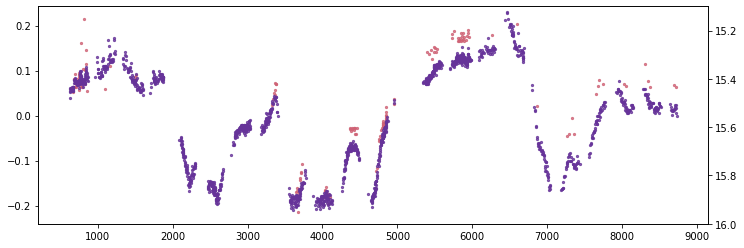

In [182]:
#vi vs. time
fig,ax = plt.subplots(1,1,figsize=(12,4))
ax.scatter(vband['MJD-50000'],vi,color=pink,s=5,alpha=0.8)
ax1 = ax.twinx()
ax1.scatter(iband['MJD-50000'],iband['I mag'],color='rebeccapurple',s=5,alpha=0.8)
ax1.set_ylim(16,15.1)

what does counter-clockwise involve?


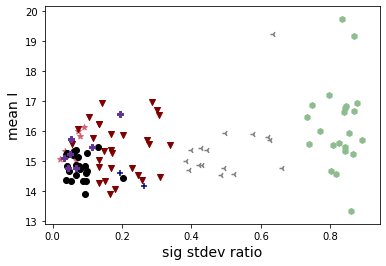

In [206]:
fulltplot(x='sig stdev ratio',y='mean I',legend=False,tbool=[False,False,False,False,False,False,False]
          ,between=True,tab=alls)
# plt.xlim(0,.2)

(-0.01, 0.42)

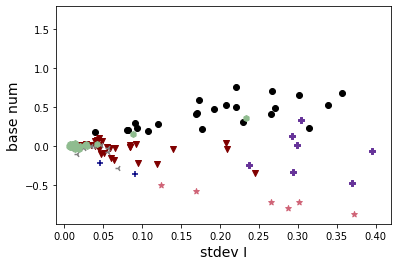

In [205]:
#mostly just interesting that transitions in same region?
fulltplot(x='stdev I',y='base num',legend=False,tbool=[False,False,False,False,False,False,False]
          ,between=True,tab=alls)
plt.xlim(-0.01,0.42)

In [248]:
acopy = alls.copy()
acopy['mean I - mean V'] = acopy['mean I'] - acopy['mean V']
acopy['stdev I - stdev V'] = acopy['stdev I'] - acopy['stdev V']

(0.45, 0.75)

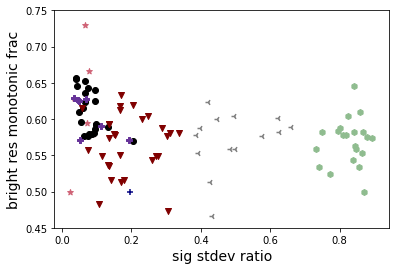

In [221]:
fulltplot(x='sig stdev ratio',y='bright res monotonic frac',legend=False,tbool=[False,False,False,False,False,False,False]
          ,between=True,tab=alls)
plt.ylim(.45,.75)

(0, 0.35)

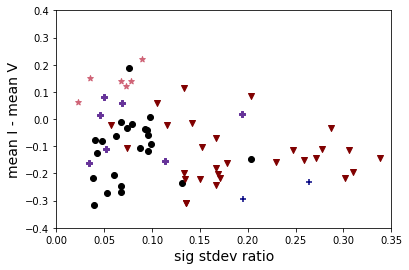

In [247]:
#type 2 outlier (in type 1 area) is src 14 (see below)
fulltplot(x='sig stdev ratio',y='mean I - mean V',legend=False,tbool=[False,False,False,False,False,False,False]
          ,between=True,tab=acopy)
plt.ylim(-.4,.4)
plt.xlim(0,.35)

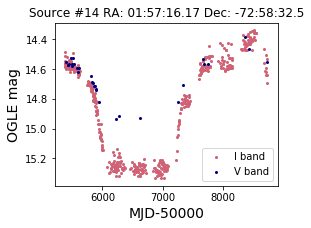

In [230]:
plot(14)

(0, 0.35)

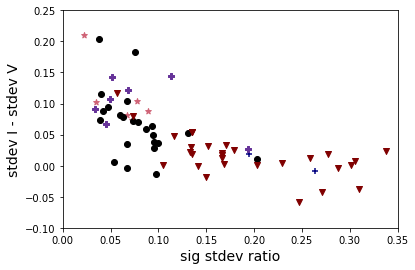

In [250]:
fulltplot(x='sig stdev ratio',y='stdev I - stdev V',legend=False,tbool=[False,False,False,False,False,False,False]
          ,between=True,tab=acopy)
plt.ylim(-.1,.25)
plt.xlim(0,.35)

In [236]:
52 in type5

False

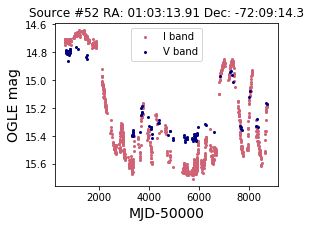

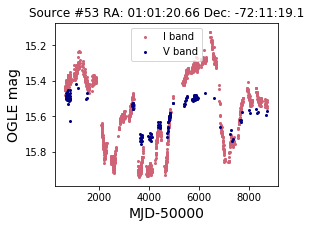

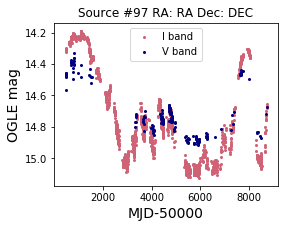

In [246]:
#the future of taxonomy
plot(52)
plot(53)
plot(97)

# Example Types

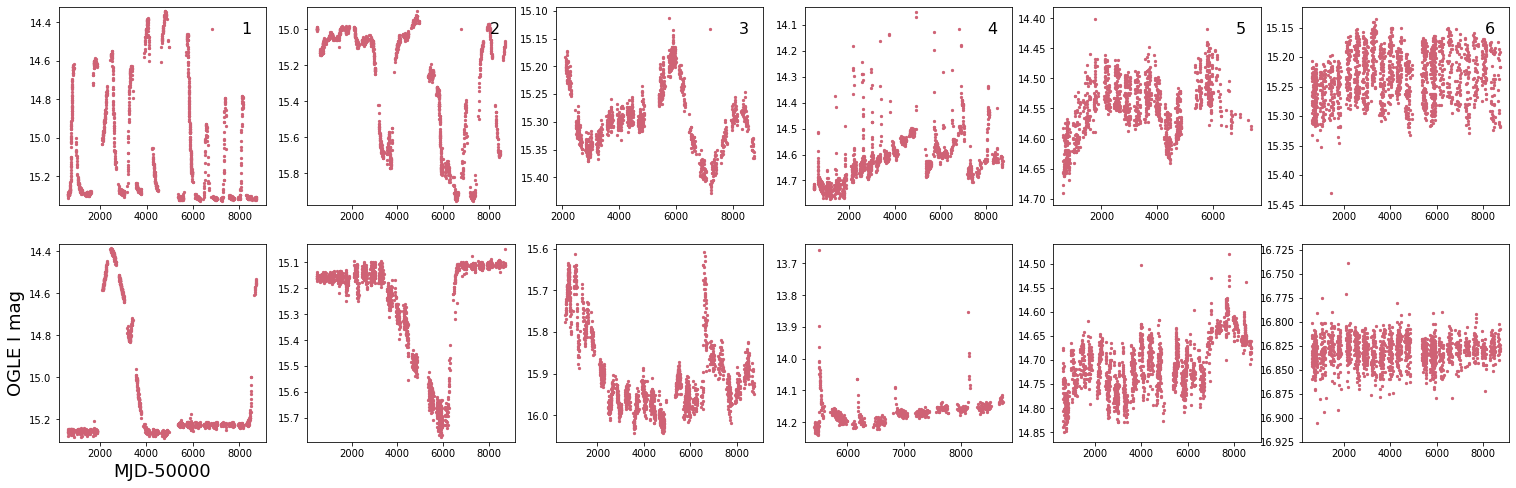

In [164]:
# reps = [type1[0],type1[3], #new type 1
#         type2[6],type3[6], #new type 2
#         type5[4],6, #3
#         60,63, #4
#         type6[4],type6[8], #new type 5
#         type7[3],type7[5]]
reps = [type1[0],type2[6],type5[4],60,type6[4],type7[3],type1[3],type3[6],6,63,type6[8],type7[7]]
fig = plt.figure(figsize=(26,8))
i = 1
for r in reps:
    ax = fig.add_subplot(2,6,i)
    if r == type7[7]: calib=True
    else: calib=False
    try:iband = o.getIV(r,cross,both=False,stack=True,plot=False,mlist=mlist1,figsize=(4,3),calib=calib)
    except:iband = o.getIV(r,cross2,both=False,stack=True,plot=False,mlist=mlist2,figsize=(4,3),calib=calib)
    ax.scatter(iband['MJD-50000'],iband['I mag'],s=5,color=pink,label=str((i)))
    mini,maxi = np.min(iband['I mag']),np.max(iband['I mag'])
    ax.set_ylim(maxi+.02,mini-.02)
    if i==7:
        ax.set_ylabel('OGLE I mag',fontsize=18)
        ax.set_xlabel('MJD-50000',fontsize=18)
#     #labels
#     if i==1: ax.text(7000,14.6,'1',fontsize=14)
#     elif i==2: ax.text(1800,15.8,'2',fontsize=14)
#     elif i==3: ax.text(7000,15.2,'3',fontsize=14)
#     elif i==4: ax.text(1800,14.2,'4',fontsize=14)
#     elif i==5: ax.text(6000,14.65,'5',fontsize=14)
#     elif i==6: ax.text(7000,15.4,'6',fontsize=14)
    if i<7: ax.legend(loc='upper right',frameon=False,fontsize=16)
    i += 1
# sf('exampletypes')